In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import shap
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [2]:
df2 = pd.read_csv("preprocessed_data_v3_pump.csv")
df2

,index,Device_Code,age,Hemoglobin_A1c,height_m,weight_kg,BMI,obesity_category,sex_F,sex_M,race_AMERICAN INDIAN/ALASKAN NATIVE,race_ASIAN,race_BLACK/AFRICAN AMERICAN,race_MULTIPLE,race_UNKNOWN,race_WHITE,ethnicity_Hispanic or Latino,ethnicity_Not Hispanic or Latino,ethnicity_UNKNOWN,insulin_delivery_MULTIPLE DAILY INJECTIONS,insulin_delivery_PUMP OR CLOSED LOOP,measure_sequence,Physicial_Activity,Calories_Burned,Heart_Rate,Insulin,Dietary_Total_Carbohydrate,Glucose,month,day,day_name,hour,hour_name,Insulin_Category,Dietary_Category
0,101,2,14.0,7.6,1.6256,79.378600,30.038349,3,1,0,0,0,0,0,0,1,0,1,0,0,1,1.0,0,0.0,82.708640,1.354,0.0,173.000000,12,25,6,0,1,3,0
1,101,2,14.0,7.6,1.6256,79.378600,30.038349,3,1,0,0,0,0,0,0,1,0,1,0,0,1,2.0,0,0.0,91.571429,0.000,0.0,185.333333,12,25,6,0,1,0,0
2,101,2,14.0,7.6,1.6256,79.378600,30.038349,3,1,0,0,0,0,0,0,1,0,1,0,0,1,3.0,0,0.0,88.933333,0.000,0.0,189.333333,12,25,6,0,1,0,0
3,101,2,14.0,7.6,1.6256,79.378600,30.038349,3,1,0,0,0,0,0,0,1,0,1,0,0,1,4.0,0,0.0,89.683333,2.070,0.0,191.333333,12,25,6,0,1,3,0
4,101,2,14.0,7.6,1.6256,79.378600,30.038349,3,1,0,0,0,0,0,0,1,0,1,0,0,1,5.0,0,0.0,96.750000,0.000,0.0,182.000000,12,25,6,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223121,99,2,12.0,6.3,1.6256,57.606184,21.799259,1,1,0,0,0,0,0,0,1,0,1,0,0,1,956.0,0,0.0,82.708640,0.000,0.0,129.666667,10,15,5,22,8,0,0
223122,99,2,12.0,6.3,1.6256,57.606184,21.799259,1,1,0,0,0,0,0,0,1,0,1,0,0,1,957.0,0,0.0,82.708640,0.000,0.0,143.000000,10,15,5,23,8,0,0
223123,99,2,12.0,6.3,1.6256,57.606184,21.799259,1,1,0,0,0,0,0,0,1,0,1,0,0,1,958.0,0,0.0,82.708640,0.000,0.0,132.000000,10,15,5,23,8,0,0
223124,99,2,12.0,6.3,1.6256,57.606184,21.799259,1,1,0,0,0,0,0,0,1,0,1,0,0,1,959.0,0,0.0,82.708640,0.000,0.0,125.000000,10,15,5,23,8,0,0


In [3]:
df2['index'].nunique()

224

## data preprocessing: x and y for both models

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

2025-07-09 15:59:19.653253: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-09 15:59:19.657655: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-09 15:59:19.666156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752094759.678016 1201733 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752094759.681562 1201733 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752094759.692479 1201733 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [5]:
# Step 1: Split data into train and test sets based on unique patient index
random_seed = 12
unique_patients = df2['index'].unique()
train_patients, test_patients = train_test_split(unique_patients, test_size=0.1, random_state=random_seed)

train_data = df2[df2['index'].isin(train_patients)]
test_data = df2[df2['index'].isin(test_patients)]

In [6]:
# Step 2: Features for the machine learning model
features = [
    'age', 'Hemoglobin_A1c', 'height_m', 'weight_kg', 'BMI', 'obesity_category', 'sex_F', 'sex_M', 
    'Physicial_Activity', 'Calories_Burned', 'race_AMERICAN INDIAN/ALASKAN NATIVE', 'race_ASIAN', 
    'race_BLACK/AFRICAN AMERICAN', 'race_MULTIPLE', 'race_UNKNOWN', 'race_WHITE', 
    'ethnicity_Hispanic or Latino', 'ethnicity_Not Hispanic or Latino', 'ethnicity_UNKNOWN', 
    'Heart_Rate', 'Insulin', 'Dietary_Total_Carbohydrate', 'Glucose', 'month', 'day', 'day_name', 
    'hour', 'hour_name']

In [7]:
# Step 3: Create sequences with sliding window
def create_sequences(data, features, seq_length, slide_step, glucose_prediction_length):
    sequences = []
    insulin_targets = []
    dietary_targets = []
    glucose_targets = []
    activity_targets = []
    
    for patient_id in data['index'].unique():
        patient_data = data[data['index'] == patient_id].sort_values(by='measure_sequence')

        for start in range(0, len(patient_data) - seq_length, slide_step):
            seq_input = patient_data.iloc[start:start + seq_length][features].values
            
            # Targets: next 15 min Insulin_Category, next 15 min Dietary_Category, next hour Glucose fluctuation
            next_15m_insulin = patient_data.iloc[start + seq_length]['Insulin_Category']
            next_15m_dietary = patient_data.iloc[start + seq_length]['Dietary_Category']
            next_15m_activity = patient_data.iloc[start + seq_length]['Physicial_Activity']
            next_hour_glucose = patient_data.iloc[start + seq_length:start + seq_length + glucose_prediction_length]['Glucose'].values

            if len(next_hour_glucose) == glucose_prediction_length:  # Ensure sufficient data for next hour's glucose
                sequences.append(seq_input)
                insulin_targets.append(next_15m_insulin)
                dietary_targets.append(next_15m_dietary)
                activity_targets.append(next_15m_activity)
                glucose_targets.append(next_hour_glucose)

    return (
        np.array(sequences),
        np.array(insulin_targets),
        np.array(dietary_targets),
        np.array(activity_targets),
        np.array(glucose_targets))  

In [8]:
historical_time_window = 24*4
sliding_window = 1
glucose_time_window = 3*4

In [9]:
# Generate sequences and targets for testing
test_sequences, test_insulin_targets, test_dietary_targets, test_activity_targets, test_glucose_targets = create_sequences(
    test_data, features, seq_length=historical_time_window, 
    slide_step=sliding_window, glucose_prediction_length=glucose_time_window)

In [10]:
# Generate sequences and targets for training 
train_sequences, train_insulin_targets, train_dietary_targets, train_activity_targets, train_glucose_targets = create_sequences(
    train_data, features, seq_length=historical_time_window, 
    slide_step=sliding_window, glucose_prediction_length=glucose_time_window)

In [11]:
test_sequences

array([[[16.    ,  7.0844,  1.6764, ...,  3.    ,  0.    ,  1.    ],
        [16.    ,  7.0844,  1.6764, ...,  3.    ,  0.    ,  1.    ],
        [16.    ,  7.0844,  1.6764, ...,  3.    ,  0.    ,  1.    ],
        ...,
        [16.    ,  7.0844,  1.6764, ...,  3.    , 23.    ,  8.    ],
        [16.    ,  7.0844,  1.6764, ...,  3.    , 23.    ,  8.    ],
        [16.    ,  7.0844,  1.6764, ...,  3.    , 23.    ,  8.    ]],

       [[16.    ,  7.0844,  1.6764, ...,  3.    ,  0.    ,  1.    ],
        [16.    ,  7.0844,  1.6764, ...,  3.    ,  0.    ,  1.    ],
        [16.    ,  7.0844,  1.6764, ...,  3.    ,  0.    ,  1.    ],
        ...,
        [16.    ,  7.0844,  1.6764, ...,  3.    , 23.    ,  8.    ],
        [16.    ,  7.0844,  1.6764, ...,  3.    , 23.    ,  8.    ],
        [16.    ,  7.0844,  1.6764, ...,  4.    ,  0.    ,  1.    ]],

       [[16.    ,  7.0844,  1.6764, ...,  3.    ,  0.    ,  1.    ],
        [16.    ,  7.0844,  1.6764, ...,  3.    ,  0.    ,  1.    ],
    

In [12]:
test_insulin_targets

array([3., 2., 3., ..., 0., 0., 3.])

In [13]:
test_dietary_targets

array([0., 0., 0., ..., 0., 0., 0.])

In [14]:
test_glucose_targets

array([[239.        , 213.33333333, 221.33333333, ..., 143.        ,
        141.33333333, 148.        ],
       [213.33333333, 221.33333333, 214.        , ..., 141.33333333,
        148.        , 155.33333333],
       [221.33333333, 214.        , 194.33333333, ..., 148.        ,
        155.33333333, 162.66666667],
       ...,
       [152.        , 138.33333333, 115.66666667, ..., 129.66666667,
        143.        , 132.        ],
       [138.33333333, 115.66666667, 113.66666667, ..., 143.        ,
        132.        , 125.        ],
       [115.66666667, 113.66666667, 118.66666667, ..., 132.        ,
        125.        , 113.66666667]])

In [15]:
# Output the shape of prepared data
print("Train sequences shape:", train_sequences.shape)
print("Train insulin targets shape:", train_insulin_targets.shape)
print("Train dietary targets shape:", train_dietary_targets.shape)
print("Train activity targets shape:", train_activity_targets.shape)
print("Train glucose targets shape:", train_glucose_targets.shape)

print("Test sequences shape:", test_sequences.shape)
print("Test insulin targets shape:", test_insulin_targets.shape)
print("Test dietary targets shape:", test_dietary_targets.shape)
print("Test activity targets shape:", test_activity_targets.shape)
print("Test glucose targets shape:", test_glucose_targets.shape)

Train sequences shape: (179562, 96, 28)
Train insulin targets shape: (179562,)
Train dietary targets shape: (179562,)
Train activity targets shape: (179562,)
Train glucose targets shape: (179562, 12)
Test sequences shape: (19596, 96, 28)
Test insulin targets shape: (19596,)
Test dietary targets shape: (19596,)
Test activity targets shape: (19596,)
Test glucose targets shape: (19596, 12)


In [16]:
num_classes_insulin = df2['Insulin_Category'].nunique()
num_classes_dietary = df2['Dietary_Category'].nunique()
num_classes_activity = df2['Physicial_Activity'].nunique()

tr_insulin_targets = to_categorical(train_insulin_targets, num_classes=num_classes_insulin)
tr_dietary_targets = to_categorical(train_dietary_targets, num_classes=num_classes_dietary)
tr_activity_targets = to_categorical(train_activity_targets, num_classes=num_classes_activity)

ts_insulin_targets = to_categorical(test_insulin_targets, num_classes=num_classes_insulin)
ts_dietary_targets = to_categorical(test_dietary_targets, num_classes=num_classes_dietary)
ts_activity_targets = to_categorical(test_activity_targets, num_classes=num_classes_activity)

In [17]:
# Scale glucose targets (4 values per output, reshape appropriately)
glucose_scaler = MinMaxScaler()

tr_glucose_targets = glucose_scaler.fit_transform(
    train_glucose_targets.reshape(-1, 1)).reshape(-1, glucose_time_window)

ts_glucose_targets = glucose_scaler.transform(
    test_glucose_targets.reshape(-1, 1)).reshape(-1, glucose_time_window)

In [18]:
test_glucose_targets

array([[239.        , 213.33333333, 221.33333333, ..., 143.        ,
        141.33333333, 148.        ],
       [213.33333333, 221.33333333, 214.        , ..., 141.33333333,
        148.        , 155.33333333],
       [221.33333333, 214.        , 194.33333333, ..., 148.        ,
        155.33333333, 162.66666667],
       ...,
       [152.        , 138.33333333, 115.66666667, ..., 129.66666667,
        143.        , 132.        ],
       [138.33333333, 115.66666667, 113.66666667, ..., 143.        ,
        132.        , 125.        ],
       [115.66666667, 113.66666667, 118.66666667, ..., 132.        ,
        125.        , 113.66666667]])

In [19]:
ts_glucose_targets

array([[0.55248619, 0.48158379, 0.50368324, ..., 0.28729282, 0.28268877,
        0.30110497],
       [0.48158379, 0.50368324, 0.48342541, ..., 0.28268877, 0.30110497,
        0.3213628 ],
       [0.50368324, 0.48342541, 0.42909761, ..., 0.30110497, 0.3213628 ,
        0.34162063],
       ...,
       [0.3121547 , 0.27440147, 0.21178637, ..., 0.25046041, 0.28729282,
        0.25690608],
       [0.27440147, 0.21178637, 0.20626151, ..., 0.28729282, 0.25690608,
        0.23756906],
       [0.21178637, 0.20626151, 0.22007366, ..., 0.25690608, 0.23756906,
        0.20626151]])

In [20]:
np.any(ts_glucose_targets > 1)

np.False_

In [21]:
# Reverse scale glucose predictions
# predicted_glucose = glucose_scaler.inverse_transform(predicted_glucose.reshape(-1, 1)).reshape(-1, 4)

In [22]:
# Function to scale input sequences
def scale_sequences(train_sequences, test_sequences):
    # Reshape to 2D for scaling: (num_samples * seq_length, num_features)
    num_samples_train, seq_length, num_features = train_sequences.shape
    num_samples_test = test_sequences.shape[0]

    train_reshaped = train_sequences.reshape(-1, num_features)
    test_reshaped = test_sequences.reshape(-1, num_features)

    # Initialize MinMaxScaler
    sequence_scaler = MinMaxScaler()

    # Fit scaler on training data and transform both train and test
    train_scaled = sequence_scaler.fit_transform(train_reshaped)
    test_scaled = sequence_scaler.transform(test_reshaped)

    # Reshape back to original shape
    train_scaled = train_scaled.reshape(num_samples_train, seq_length, num_features)
    test_scaled = test_scaled.reshape(num_samples_test, seq_length, num_features)

    return train_scaled, test_scaled, sequence_scaler

In [23]:
# Scale input sequences
tr_sequences, ts_sequences, sequence_scaler = scale_sequences(train_sequences, test_sequences)

In [24]:
np.any(ts_sequences > 1)

np.False_

In [25]:
# Output the shape of prepared data
print("Train sequences shape:", tr_sequences.shape)
print("Train insulin targets shape:", tr_insulin_targets.shape)
print("Train dietary targets shape:", tr_dietary_targets.shape)
print("Train activity targets shape:", tr_activity_targets.shape)
print("Train glucose targets shape:", tr_glucose_targets.shape)

print("Test sequences shape:", ts_sequences.shape)
print("Test insulin targets shape:", ts_insulin_targets.shape)
print("Test dietary targets shape:", ts_dietary_targets.shape)
print("Test activity targets shape:", ts_activity_targets.shape)
print("Test glucose targets shape:", ts_glucose_targets.shape)

Train sequences shape: (179562, 96, 28)
Train insulin targets shape: (179562, 4)
Train dietary targets shape: (179562, 3)
Train activity targets shape: (179562, 2)
Train glucose targets shape: (179562, 12)
Test sequences shape: (19596, 96, 28)
Test insulin targets shape: (19596, 4)
Test dietary targets shape: (19596, 3)
Test activity targets shape: (19596, 2)
Test glucose targets shape: (19596, 12)


In [26]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [27]:
def create_joint_rl_model(time_series_length, feature_dim, num_insulin_classes, 
                         num_dietary_classes, num_activity_classes, output_dim):
    # Input layer for time series data
    input_time_series = layers.Input(shape=(time_series_length, feature_dim), 
                                   name='time_series_input')
    
    # First Model: RL-based action selection network
    x1 = layers.LSTM(80, return_sequences=True)(input_time_series)
    x1 = layers.LSTM(60, return_sequences=True)(x1)
    x1 = layers.LSTM(40)(x1)
    shared_dense = layers.Dense(20, activation='relu')(x1)
    
    # Q-value prediction branches for each action
    insulin_q = layers.Dense(10, activation='relu')(shared_dense)
    insulin_q = layers.Dense(num_insulin_classes, name='insulin_q')(insulin_q)
    
    dietary_q = layers.Dense(10, activation='relu')(shared_dense)
    dietary_q = layers.Dense(num_dietary_classes, name='dietary_q')(dietary_q)
    
    activity_q = layers.Dense(10, activation='relu')(shared_dense)
    activity_q = layers.Dense(num_activity_classes, name='activity_q')(activity_q)
    
    # Convert Q-values to probabilities using softmax
    insulin_prob = layers.Softmax(name='insulin_prob')(insulin_q)
    dietary_prob = layers.Softmax(name='dietary_prob')(dietary_q)
    activity_prob = layers.Softmax(name='activity_prob')(activity_q)
    
    # Second Model: Glucose Prediction Network
    predicted_actions = layers.Concatenate(axis=-1)([insulin_prob, dietary_prob, activity_prob])
    repeated_actions = layers.RepeatVector(time_series_length)(predicted_actions)
    combined_input = layers.Concatenate(axis=-1)([input_time_series, repeated_actions])
    
    x2 = layers.LSTM(80, return_sequences=True)(combined_input)
    x2 = layers.LSTM(60, return_sequences=True)(x2)
    x2 = layers.LSTM(40, return_sequences=True)(x2)
    x2 = layers.LSTM(20, return_sequences=True)(x2)
    x2 = layers.TimeDistributed(layers.Dense(10, activation='relu'))(x2)
    glucose_output = layers.Dense(output_dim, name='glucose_output')(x2[:, -1, :])
    
    # Create complete model
    model = Model(inputs=input_time_series,
                 outputs=[insulin_prob, dietary_prob, activity_prob, glucose_output])
    
    return model

In [28]:
def calculate_glucose_reward(predicted_glucose_values, target_range=(80, 180)):
    """Calculate reward based on percentage of predicted glucose values within target range"""
    low_bound, high_bound = target_range
    within_range = np.logical_and(predicted_glucose_values >= low_bound, 
                                predicted_glucose_values <= high_bound)
    percentage_within_range = np.mean(within_range)
    reward = 2 * percentage_within_range - 1  # Scale to [-1, 1]
    return reward

In [29]:
def train_joint_rl_model(model, tr_sequences, tr_insulin_targets, tr_dietary_targets, 
                        tr_activity_targets, tr_glucose_targets, glucose_scaler,
                        num_epochs=500, batch_size=32, gamma=0.8):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    # Training history
    history = {
        'rl_loss': [],
        'glucose_loss': [],
        'total_rewards': []}
    
    for epoch in range(num_epochs):
        # Sample batch
        indices = np.random.choice(len(tr_sequences), size=batch_size, replace=False)
        batch_states = tr_sequences[indices]
        batch_insulin_targets = tr_insulin_targets[indices]
        batch_dietary_targets = tr_dietary_targets[indices]
        batch_activity_targets = tr_activity_targets[indices]
        batch_glucose_targets = tr_glucose_targets[indices]
        
        with tf.GradientTape() as tape:
            # Forward pass
            insulin_q, dietary_q, activity_q, predicted_glucose = model(batch_states, 
                                                                      training=True)
            
            # Convert predicted glucose to original scale for reward calculation
            predicted_glucose_unscaled = glucose_scaler.inverse_transform(
                predicted_glucose.numpy().reshape(-1, 1)).reshape(-1, output_dim)
            
            # Calculate rewards for each sample in batch
            rewards = np.array([calculate_glucose_reward(pred_glucose) 
                              for pred_glucose in predicted_glucose_unscaled])
            
            # Calculate RL losses
            insulin_actions = tf.argmax(insulin_q, axis=1)
            dietary_actions = tf.argmax(dietary_q, axis=1)
            activity_actions = tf.argmax(activity_q, axis=1)
            
            # Create target Q-values with rewards
            target_insulin_q = tf.one_hot(insulin_actions, depth=num_insulin_classes) * rewards[:, None]
            target_dietary_q = tf.one_hot(dietary_actions, depth=num_dietary_classes) * rewards[:, None]
            target_activity_q = tf.one_hot(activity_actions, depth=num_activity_classes) * rewards[:, None]
            
            # Calculate losses
            rl_loss = (
                tf.reduce_mean(tf.square(target_insulin_q - insulin_q)) +
                tf.reduce_mean(tf.square(target_dietary_q - dietary_q)) +
                tf.reduce_mean(tf.square(target_activity_q - activity_q))
            )
            
            glucose_loss = tf.reduce_mean(tf.square(batch_glucose_targets - predicted_glucose))
            
            # Combined loss
            total_loss = rl_loss + glucose_loss
        
        # Calculate gradients and update model
        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # Update history
        history['rl_loss'].append(float(rl_loss))
        history['glucose_loss'].append(float(glucose_loss))
        history['total_rewards'].append(float(np.mean(rewards)))
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}")
            print(f"RL Loss: {float(rl_loss):.4f}")
            print(f"Glucose Loss: {float(glucose_loss):.4f}")
            print(f"Average Reward: {float(np.mean(rewards)):.4f}")
            print("--------------------")
    
    return history

In [30]:
time_series_length = tr_sequences.shape[1]
feature_dim = tr_sequences.shape[2]
num_insulin_classes = df2['Insulin_Category'].nunique()
num_activity_classes = df2['Physicial_Activity'].nunique()
num_dietary_classes = df2['Dietary_Category'].nunique()
output_dim = tr_glucose_targets.shape[1]  # Features in the sequence prediction output

print(time_series_length)
print(feature_dim)
print(num_insulin_classes)
print(num_activity_classes)
print(num_dietary_classes)
print(output_dim)

96
28
4
2
3
12


In [31]:
# Initialize model
model = create_joint_rl_model(
    time_series_length=time_series_length,
    feature_dim=feature_dim,
    num_insulin_classes=num_insulin_classes,
    num_dietary_classes=num_dietary_classes,
    num_activity_classes=num_activity_classes,
    output_dim=output_dim)

2025-07-09 16:01:06.649169: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [32]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_series_input   │ (None, 96, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 96, 80)    │     34,880 │ time_series_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 96, 60)    │     33,840 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 40)        │     16,160 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20)        │        820 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │        210 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │        210 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │        210 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ insulin_q (Dense)   │ (None, 4)         │         44 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dietary_q (Dense)   │ (None, 3)         │         33 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activity_q (Dense)  │ (None, 2)         │         22 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ insulin_prob        │ (None, 4)         │          0 │ insulin_q[0][0]   │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dietary_prob        │ (None, 3)         │          0 │ dietary_q[0][0]   │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activity_prob       │ (None, 2)         │          0 │ activity_q[0][0]  │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 9)         │          0 │ insulin_prob[0][… │
│ (Concatenate)       │                   │            │ dietary_prob[0][… │
│                     │                   │            │ activity_prob[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 96, 9)     │          0 │ concatenate[0][0] │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96, 37)    │          0 │ time_series_inpu… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 96, 80)    │     37,760 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 96, 60)    │     33,840 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 96, 40)    │     16,160 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 96, 20)    │      4,880 │ lstm_5[0][0]    

 Total params: 179,411 (700.82 KB)

 Trainable params: 179,411 (700.82 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = train_joint_rl_model(
    model=model,
    tr_sequences=tr_sequences,
    tr_insulin_targets=tr_insulin_targets,
    tr_dietary_targets=tr_dietary_targets,
    tr_activity_targets=tr_activity_targets,
    tr_glucose_targets=tr_glucose_targets,
    glucose_scaler=glucose_scaler)

Epoch 5/500
RL Loss: 1.0653
Glucose Loss: 0.1511
Average Reward: -0.4479
--------------------
Epoch 10/500
RL Loss: 0.3142
Glucose Loss: 0.0795
Average Reward: 0.1615
--------------------
Epoch 15/500
RL Loss: 0.2511
Glucose Loss: 0.0655
Average Reward: 0.3177
--------------------
Epoch 20/500
RL Loss: 0.3007
Glucose Loss: 0.0962
Average Reward: 0.1667
--------------------
Epoch 25/500
RL Loss: 0.3004
Glucose Loss: 0.0562
Average Reward: 0.1667
--------------------
Epoch 30/500
RL Loss: 0.2131
Glucose Loss: 0.1105
Average Reward: 0.3333
--------------------
Epoch 35/500
RL Loss: 0.2080
Glucose Loss: 0.0794
Average Reward: 0.3333
--------------------
Epoch 40/500
RL Loss: 0.2016
Glucose Loss: 0.0468
Average Reward: 0.3490
--------------------
Epoch 45/500
RL Loss: 0.1504
Glucose Loss: 0.0703
Average Reward: 0.5000
--------------------
Epoch 50/500
RL Loss: 0.1221
Glucose Loss: 0.0651
Average Reward: 0.6719
--------------------
Epoch 55/500
RL Loss: 0.1517
Glucose Loss: 0.0525
Average Re

In [34]:
model.save('pump_model2.keras')

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score

In [36]:
def evaluate_rl_actions(model, test_sequences, test_insulin_targets, test_dietary_targets, 
                       test_activity_targets, class_names_dict):
    """
    Evaluate the RL model's action selection performance
    """
    # Get model predictions
    insulin_probs, dietary_probs, activity_probs, _ = model.predict(test_sequences)
    
    # Convert probabilities to actions
    predicted_insulin = np.argmax(insulin_probs, axis=1)
    predicted_dietary = np.argmax(dietary_probs, axis=1)
    predicted_activity = np.argmax(activity_probs, axis=1)
    
    # Convert one-hot encoded targets to class indices
    true_insulin = np.argmax(test_insulin_targets, axis=1)
    true_dietary = np.argmax(test_dietary_targets, axis=1)
    true_activity = np.argmax(test_activity_targets, axis=1)
    
    # Calculate confusion matrices
    insulin_cm = confusion_matrix(true_insulin, predicted_insulin)
    dietary_cm = confusion_matrix(true_dietary, predicted_dietary)
    activity_cm = confusion_matrix(true_activity, predicted_activity)
    
    # Generate classification reports with explicit labels parameter
    labels = list(range(4))  # [0, 1, 2, 3] for 4 classes
    
    insulin_report = classification_report(true_insulin, predicted_insulin, 
                                        labels=labels,
                                        target_names=class_names_dict['insulin'])
    dietary_report = classification_report(true_dietary, predicted_dietary, 
                                         labels=labels,
                                         target_names=class_names_dict['dietary'])
    activity_report = classification_report(true_activity, predicted_activity, 
                                          labels=labels,
                                          target_names=class_names_dict['activity'])
    
    # Plot confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Insulin confusion matrix
    sns.heatmap(insulin_cm, annot=True, fmt='d', ax=axes[0],
                xticklabels=class_names_dict['insulin'],
                yticklabels=class_names_dict['insulin'])
    axes[0].set_title('Insulin Action Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    
    # Dietary confusion matrix
    sns.heatmap(dietary_cm, annot=True, fmt='d', ax=axes[1],
                xticklabels=class_names_dict['dietary'],
                yticklabels=class_names_dict['dietary'])
    axes[1].set_title('Dietary Action Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    
    # Activity confusion matrix
    sns.heatmap(activity_cm, annot=True, fmt='d', ax=axes[2],
                xticklabels=class_names_dict['activity'],
                yticklabels=class_names_dict['activity'])
    axes[2].set_title('Activity Action Confusion Matrix')
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('True')
    
    plt.tight_layout()
    plt.show()
    
    # Print classification reports
    print("\nInsulin Classification Report:")
    print(insulin_report)
    print("\nDietary Classification Report:")
    print(dietary_report)
    print("\nActivity Classification Report:")
    print(activity_report)
    
    return {
        'insulin_cm': insulin_cm,
        'dietary_cm': dietary_cm,
        'activity_cm': activity_cm,
        'insulin_report': insulin_report,
        'dietary_report': dietary_report,
        'activity_report': activity_report
    }

In [37]:
def evaluate_glucose_predictions(model, test_sequences, test_glucose_targets, glucose_scaler, 
                               target_range=(80, 180)):
    """
    Evaluate the glucose prediction performance
    """
    # Get model predictions
    _, _, _, predicted_glucose = model.predict(test_sequences)
    
    # Inverse transform predictions and targets back to original scale
    predicted_glucose_unscaled = glucose_scaler.inverse_transform(
        predicted_glucose.reshape(-1, 1)).reshape(-1, predicted_glucose.shape[1])
    true_glucose_unscaled = glucose_scaler.inverse_transform(
        test_glucose_targets.reshape(-1, 1)).reshape(-1, test_glucose_targets.shape[1])
    
    # Calculate metrics
    mse = mean_squared_error(true_glucose_unscaled, predicted_glucose_unscaled)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_glucose_unscaled, predicted_glucose_unscaled)
    r2 = r2_score(true_glucose_unscaled.flatten(), predicted_glucose_unscaled.flatten())
    
    # Calculate time in range metrics
    in_range_true = np.logical_and(true_glucose_unscaled >= target_range[0], 
                                  true_glucose_unscaled <= target_range[1])
    in_range_pred = np.logical_and(predicted_glucose_unscaled >= target_range[0], 
                                  predicted_glucose_unscaled <= target_range[1])
    
    time_in_range_true = np.mean(in_range_true) * 100
    time_in_range_pred = np.mean(in_range_pred) * 100
    
    # Plot predictions vs actual for a random sample
    num_samples = min(5, len(test_sequences))
    sample_indices = np.random.choice(len(test_sequences), num_samples, replace=False)
    
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(sample_indices, 1):
        plt.subplot(num_samples, 1, i)
        plt.plot(true_glucose_unscaled[idx], label='Actual', marker='o')
        plt.plot(predicted_glucose_unscaled[idx], label='Predicted', marker='s')
        plt.axhline(y=target_range[0], color='r', linestyle='--', alpha=0.3)
        plt.axhline(y=target_range[1], color='r', linestyle='--', alpha=0.3)
        plt.fill_between([0, len(true_glucose_unscaled[idx])], 
                        target_range[0], target_range[1], 
                        alpha=0.1, color='green')
        plt.legend()
        plt.title(f'Sample {i} - Glucose Prediction vs Actual')
        plt.ylabel('Glucose (mg/dL)')
    
    plt.tight_layout()
    plt.show()
    
    # Create error distribution plot
    errors = predicted_glucose_unscaled.flatten() - true_glucose_unscaled.flatten()
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True)
    plt.title('Distribution of Prediction Errors')
    plt.xlabel('Prediction Error (mg/dL)')
    plt.ylabel('Count')
    plt.show()
    
    # Print metrics
    print("\nGlucose Prediction Metrics:")
    print(f"Root Mean Square Error: {rmse:.2f} mg/dL")
    print(f"Mean Absolute Error: {mae:.2f} mg/dL")
    print(f"R² Score: {r2:.4f}")
    print(f"Actual Time in Range: {time_in_range_true:.1f}%")
    print(f"Predicted Time in Range: {time_in_range_pred:.1f}%")
    
    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'time_in_range_true': time_in_range_true,
        'time_in_range_pred': time_in_range_pred,
        'errors': errors
    }

In [38]:
def plot_training_history(history):
    """
    Plot the training history metrics
    """
    plt.figure(figsize=(15, 5))
    
    # Plot RL and glucose losses
    plt.subplot(1, 2, 1)
    plt.plot(history['rl_loss'], label='RL Loss')
    plt.plot(history['glucose_loss'], label='Glucose Loss')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot average rewards
    plt.subplot(1, 2, 2)
    plt.plot(history['total_rewards'], label='Average Reward')
    plt.title('Average Rewards During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Reward')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

613/613 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step


/home/kcmnf/.conda/envs/ml_env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kcmnf/.conda/envs/ml_env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kcmnf/.conda/envs/ml_env2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

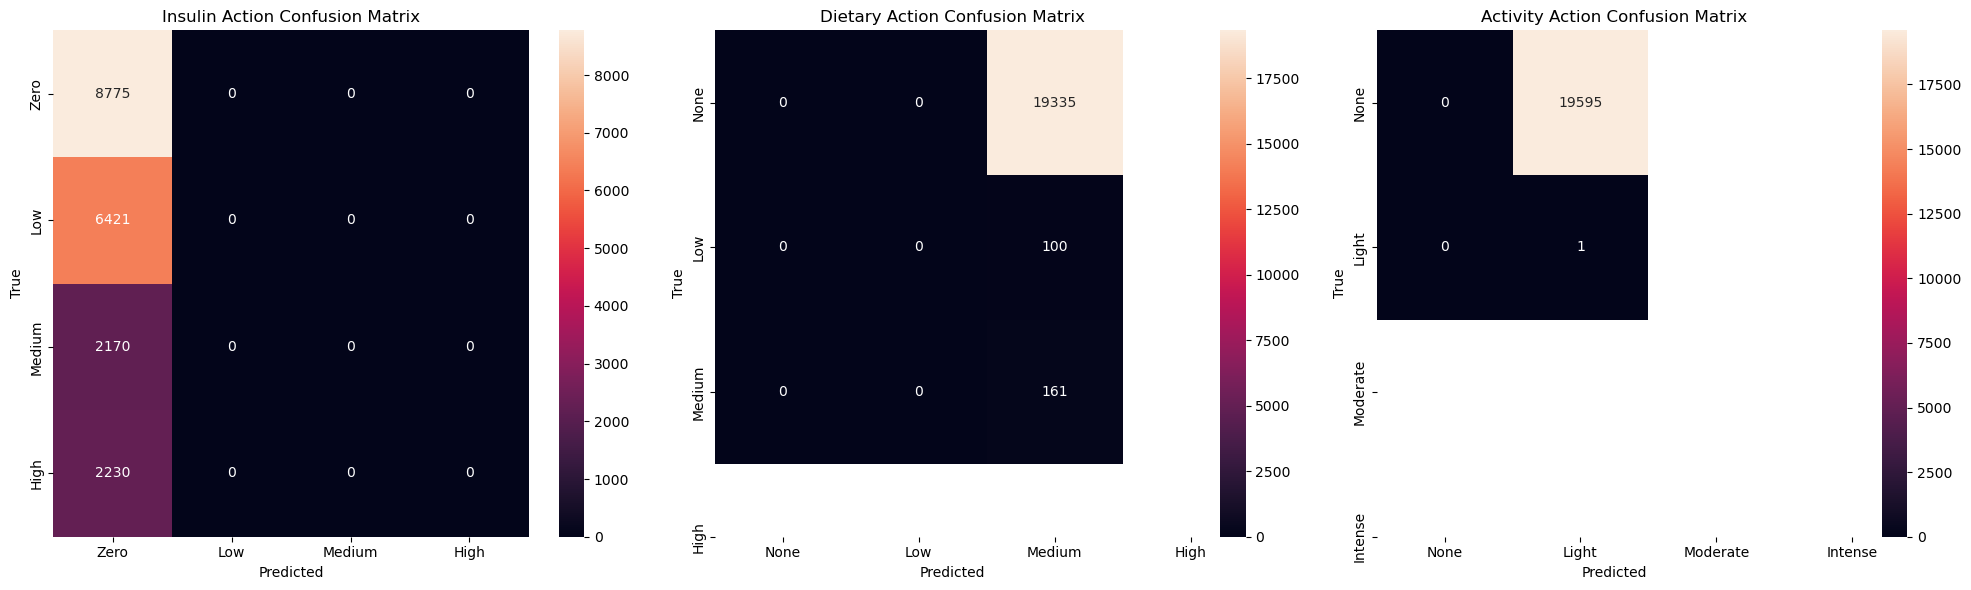


Insulin Classification Report:
              precision    recall  f1-score   support

        Zero       0.45      1.00      0.62      8775
         Low       0.00      0.00      0.00      6421
      Medium       0.00      0.00      0.00      2170
        High       0.00      0.00      0.00      2230

    accuracy                           0.45     19596
   macro avg       0.11      0.25      0.15     19596
weighted avg       0.20      0.45      0.28     19596


Dietary Classification Report:
              precision    recall  f1-score   support

        None       0.00      0.00      0.00     19335
         Low       0.00      0.00      0.00       100
      Medium       0.01      1.00      0.02       161
        High       0.00      0.00      0.00         0

    accuracy                           0.01     19596
   macro avg       0.00      0.25      0.00     19596
weighted avg       0.00      0.01      0.00     19596


Activity Classification Report:
              precision    recall

In [39]:
class_names_dict = {
    'insulin': ['Zero', 'Low', 'Medium', 'High'],  # Changed to 4 classes
    'dietary': ['None', 'Low', 'Medium', 'High'],  # Already correct with 4 classes
    'activity': ['None', 'Light', 'Moderate', 'Intense']  # Already correct with 4 classes
}

# Evaluate the model
rl_metrics = evaluate_rl_actions(
    model, 
    ts_sequences, 
    ts_insulin_targets, 
    ts_dietary_targets, 
    ts_activity_targets, 
    class_names_dict)

613/613 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step


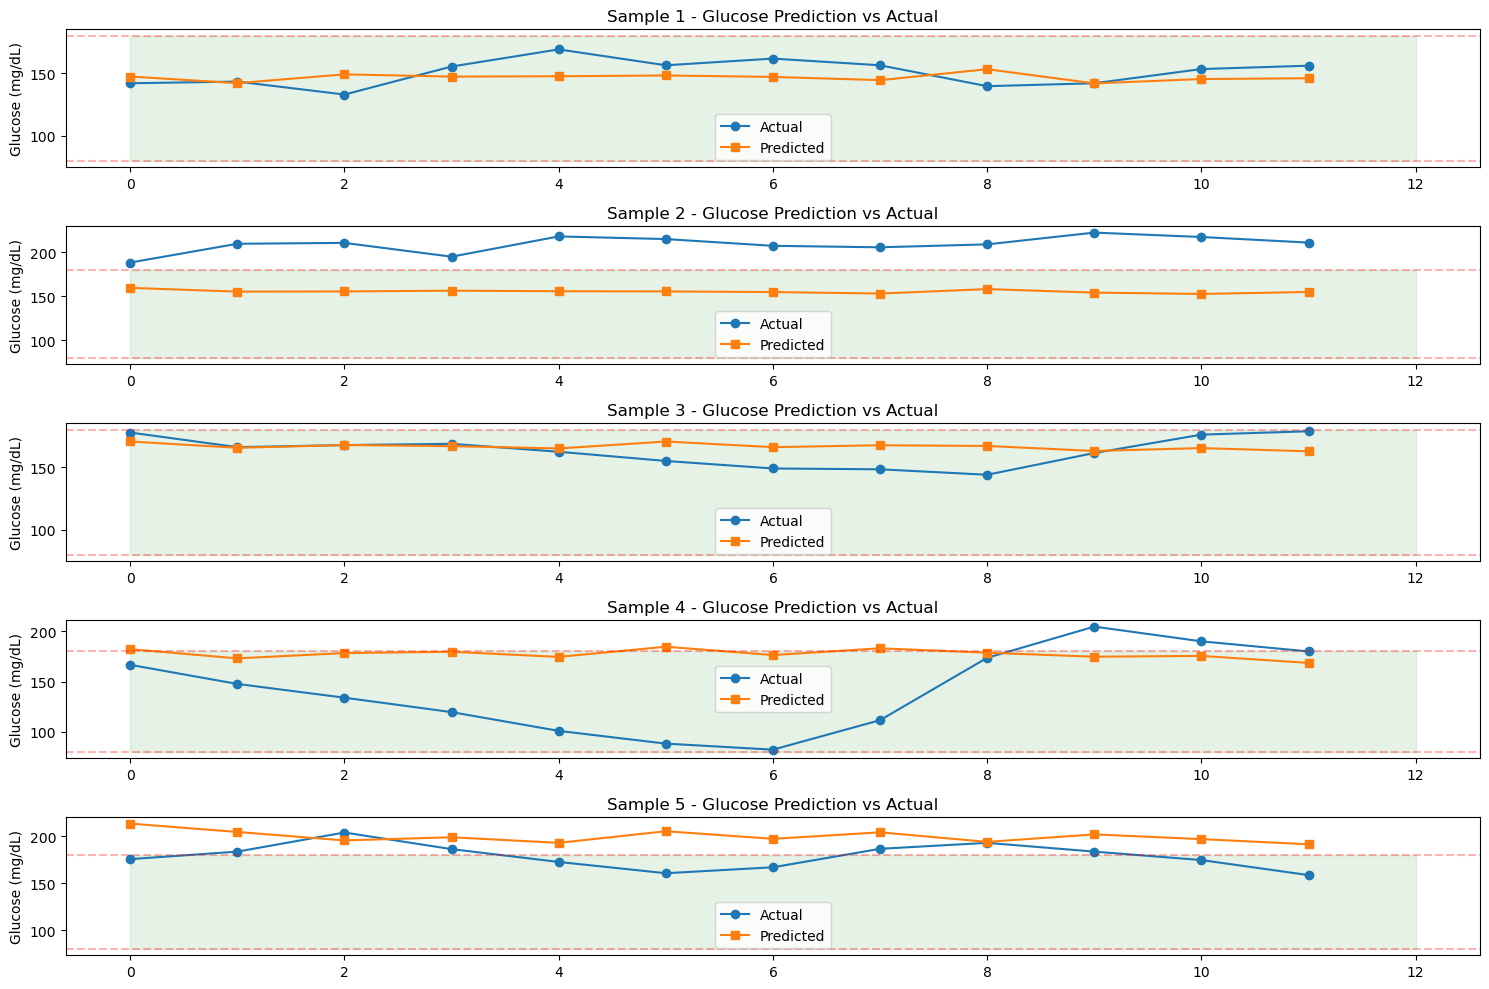

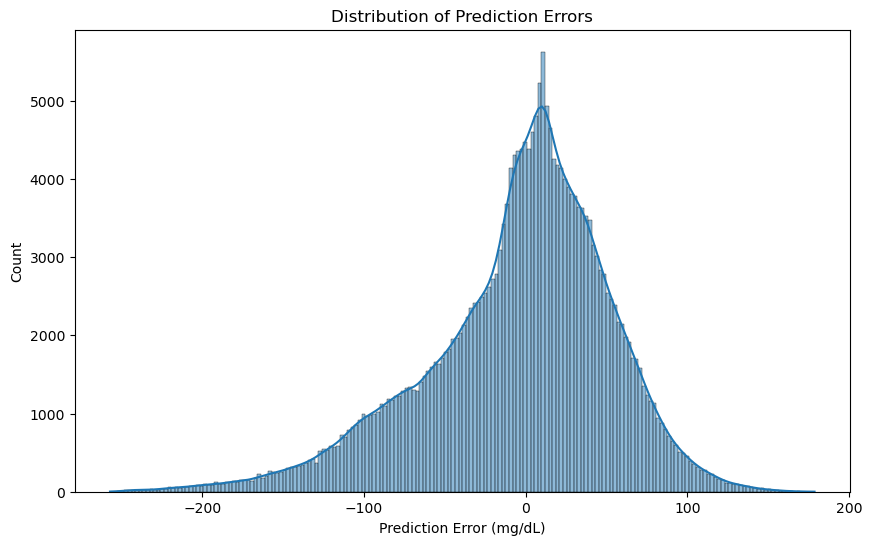


Glucose Prediction Metrics:
Root Mean Square Error: 57.95 mg/dL
Mean Absolute Error: 43.82 mg/dL
R² Score: 0.1376
Actual Time in Range: 61.6%
Predicted Time in Range: 80.2%


In [40]:
glucose_metrics = evaluate_glucose_predictions(
    model,
    ts_sequences,
    ts_glucose_targets,
    glucose_scaler,
    target_range=(80, 180))

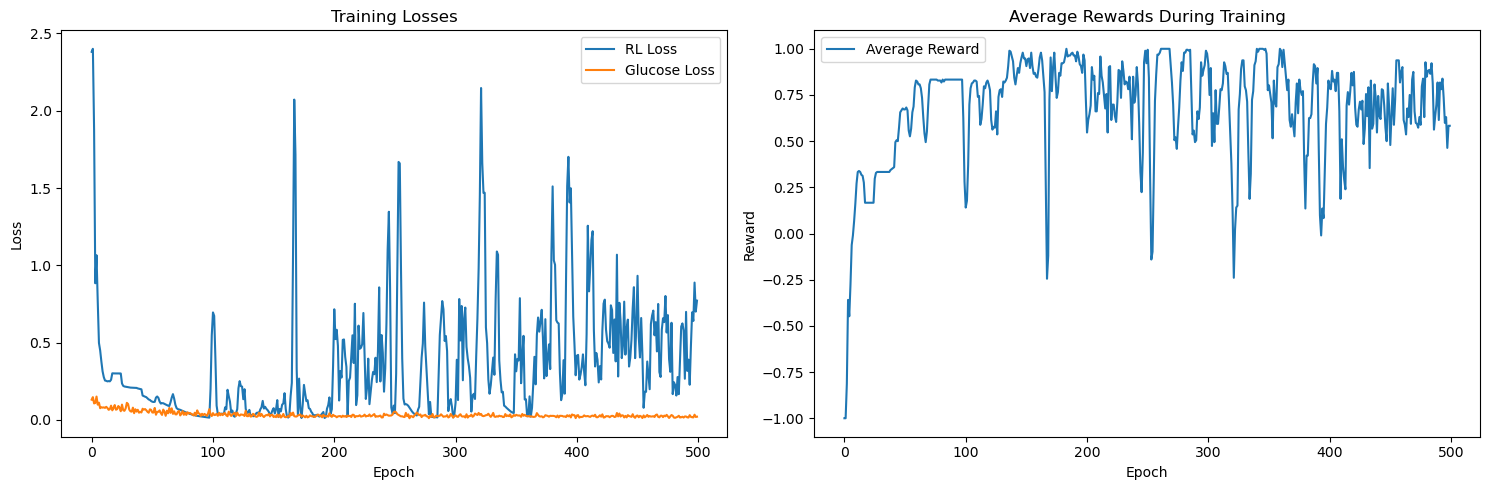

In [41]:
# Plot training history
plot_training_history(history)

In [42]:
def compare_glucose_control(model, ts_sequences, ts_glucose_targets, glucose_scaler, 
                          target_range=(80, 180)):
    """
    Compare algorithm's glucose control performance against human behavior
    
    Parameters:
    - model: trained joint RL model
    - ts_sequences: test sequence data
    - ts_glucose_targets: actual glucose values from test set
    - glucose_scaler: scaler used for glucose values
    - target_range: tuple of (min, max) target glucose range
    """
    # Get model predictions
    _, _, _, predicted_glucose = model.predict(ts_sequences)
    
    # Inverse transform predictions and actual values back to original scale
    predicted_glucose_unscaled = glucose_scaler.inverse_transform(
        predicted_glucose.reshape(-1, 1)).reshape(-1, predicted_glucose.shape[1])
    true_glucose_unscaled = glucose_scaler.inverse_transform(
        ts_glucose_targets.reshape(-1, 1)).reshape(-1, ts_glucose_targets.shape[1])
    
    # Calculate in-range percentages for each sequence
    def calculate_in_range_percentage(glucose_values, target_range):
        in_range = np.logical_and(glucose_values >= target_range[0], 
                                glucose_values <= target_range[1])
        return np.mean(in_range) * 100
    
    # Calculate percentages for each sequence
    human_percentages = np.array([
        calculate_in_range_percentage(seq, target_range) 
        for seq in true_glucose_unscaled
    ])
    
    algorithm_percentages = np.array([
        calculate_in_range_percentage(seq, target_range) 
        for seq in predicted_glucose_unscaled
    ])
    
    # Compare performance
    better_than_human = algorithm_percentages > human_percentages
    percentage_better = np.mean(better_than_human) * 100
    
    # Calculate overall statistics
    overall_stats = {
        'human_mean_in_range': np.mean(human_percentages),
        'algorithm_mean_in_range': np.mean(algorithm_percentages),
        'percentage_better_than_human': percentage_better,
        'human_median_in_range': np.median(human_percentages),
        'algorithm_median_in_range': np.median(algorithm_percentages),
        'human_std_in_range': np.std(human_percentages),
        'algorithm_std_in_range': np.std(algorithm_percentages)
    }
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Distribution comparison
    plt.subplot(2, 1, 1)
    plt.hist(human_percentages, alpha=0.5, label='Human', bins=50)
    plt.hist(algorithm_percentages, alpha=0.5, label='Algorithm', bins=50)
    plt.xlabel('Percentage of Time in Range')
    plt.ylabel('Frequency')
    plt.title('Distribution of Time in Range: Human vs Algorithm')
    plt.legend()
    
    # Plot 2: Box plot comparison
    plt.subplot(2, 1, 2)
    plt.boxplot([human_percentages, algorithm_percentages], 
                labels=['Human', 'Algorithm'])
    plt.ylabel('Percentage of Time in Range')
    plt.title('Time in Range Comparison: Human vs Algorithm')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\nPerformance Comparison Statistics:")
    print(f"Human Control:")
    print(f"- Mean time in range: {overall_stats['human_mean_in_range']:.1f}%")
    print(f"- Median time in range: {overall_stats['human_median_in_range']:.1f}%")
    print(f"- Standard deviation: {overall_stats['human_std_in_range']:.1f}%")
    print("\nAlgorithm Control:")
    print(f"- Mean time in range: {overall_stats['algorithm_mean_in_range']:.1f}%")
    print(f"- Median time in range: {overall_stats['algorithm_median_in_range']:.1f}%")
    print(f"- Standard deviation: {overall_stats['algorithm_std_in_range']:.1f}%")
    print(f"\nAlgorithm performs better than human in {percentage_better:.1f}% of cases")
    
    # Calculate detailed comparison metrics
    improvement_when_better = np.mean(
        algorithm_percentages[better_than_human] - 
        human_percentages[better_than_human]
    ) if any(better_than_human) else 0
    
    deterioration_when_worse = np.mean(
        human_percentages[~better_than_human] - 
        algorithm_percentages[~better_than_human]
    ) if any(~better_than_human) else 0
    
    print(f"\nWhen algorithm performs better:")
    print(f"- Average improvement: {improvement_when_better:.1f}%")
    print(f"\nWhen algorithm performs worse:")
    print(f"- Average deterioration: {deterioration_when_worse:.1f}%")
    
    return {
        'overall_stats': overall_stats,
        'human_percentages': human_percentages,
        'algorithm_percentages': algorithm_percentages,
        'better_than_human': better_than_human,
        'improvement_when_better': improvement_when_better,
        'deterioration_when_worse': deterioration_when_worse
    }

613/613 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step


/tmp/ipykernel_1201733/4214187428.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([human_percentages, algorithm_percentages],


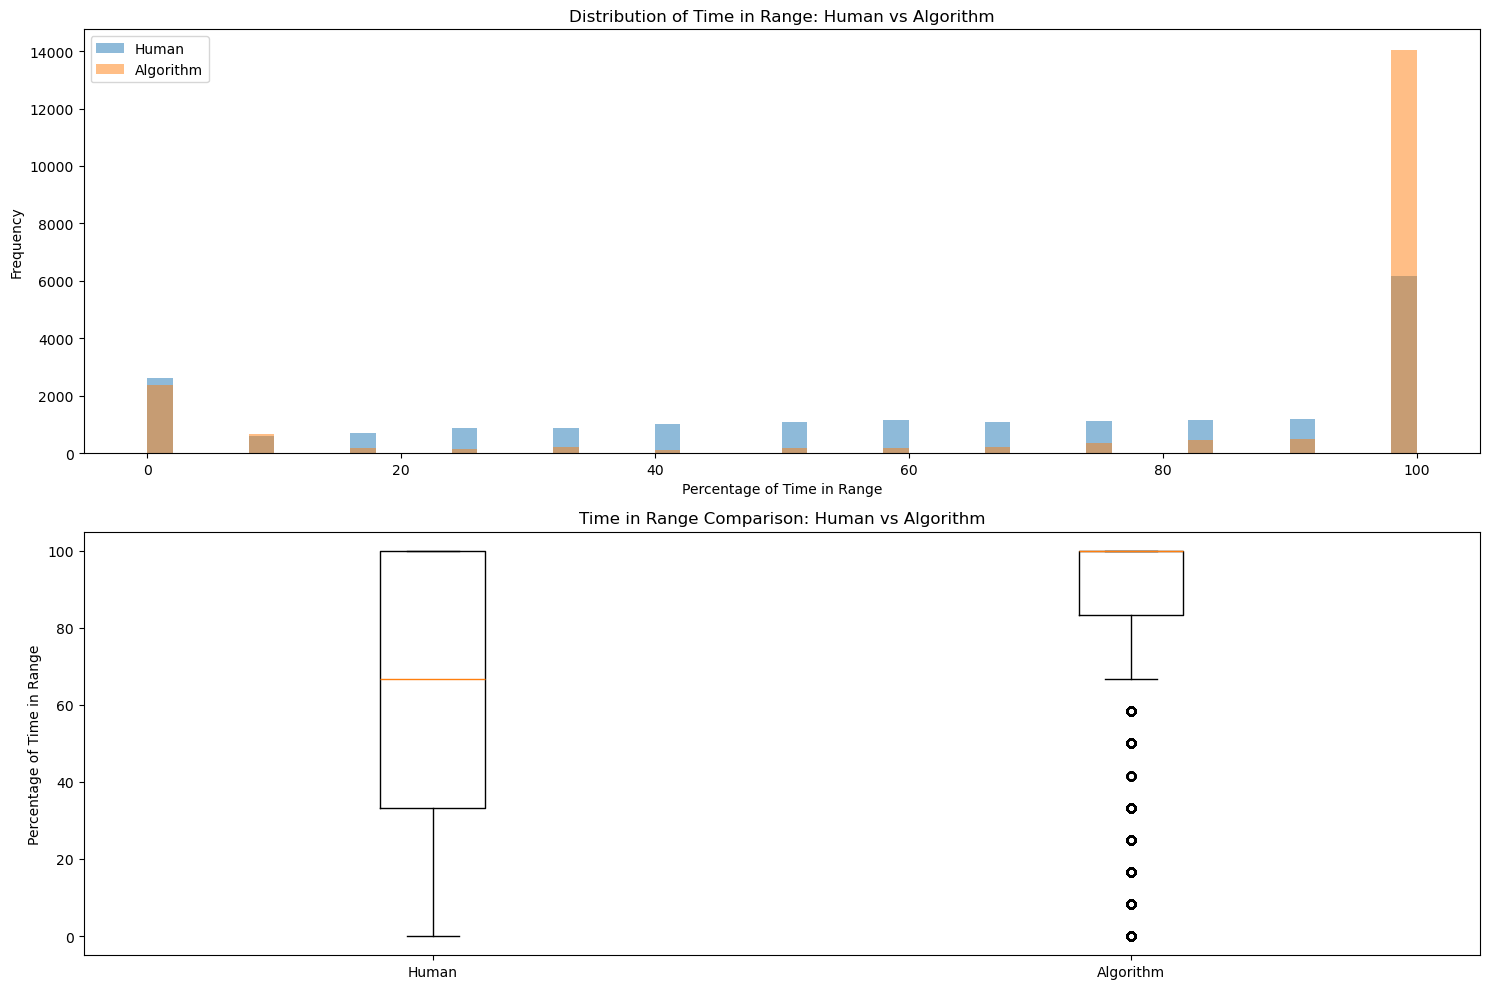


Performance Comparison Statistics:
Human Control:
- Mean time in range: 61.6%
- Median time in range: 66.7%
- Standard deviation: 36.7%

Algorithm Control:
- Mean time in range: 80.2%
- Median time in range: 100.0%
- Standard deviation: 36.7%

Algorithm performs better than human in 51.3% of cases

When algorithm performs better:
- Average improvement: 47.9%

When algorithm performs worse:
- Average deterioration: 12.3%


In [43]:
results = compare_glucose_control(
    model=model,
    ts_sequences=ts_sequences,
    ts_glucose_targets=ts_glucose_targets,
    glucose_scaler=glucose_scaler,
    target_range=(80, 180)
)

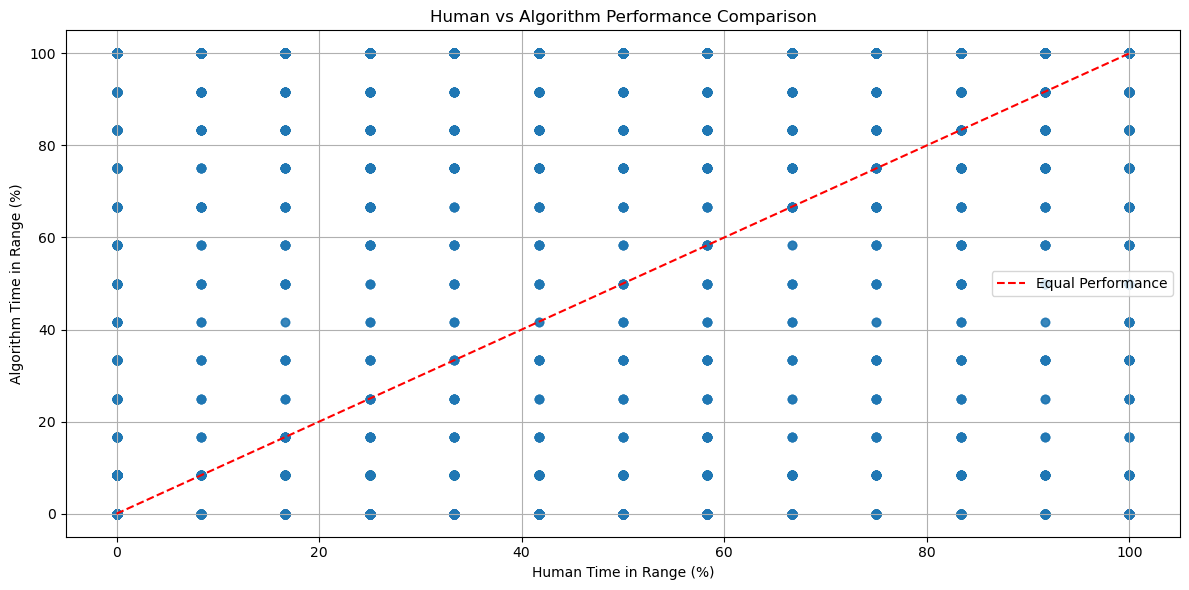


Detailed Performance Comparison:
Cases where human outperformed algorithm: 2749 (14.0%)
When human performed better:
- Average improvement: 42.7%
- Maximum improvement: 100.0%
- Minimum improvement: 8.3%
- Standard deviation: 27.0%


In [44]:
def analyze_performance_comparison(human_percentages, algorithm_percentages):
    """
    Detailed analysis of cases where human management outperformed the algorithm
    
    Parameters:
    - human_percentages: Array of time-in-range percentages for human management
    - algorithm_percentages: Array of time-in-range percentages for algorithm
    
    Returns:
    - Dictionary containing detailed comparison metrics
    """
    # Calculate cases where human outperformed algorithm
    human_better = human_percentages > algorithm_percentages
    human_better_percentage = np.mean(human_better) * 100
    
    # Calculate magnitude of difference when human was better
    difference_when_human_better = np.mean(
        human_percentages[human_better] - algorithm_percentages[human_better]
    ) if any(human_better) else 0
    
    # Find specific cases with largest human advantage
    differences = human_percentages - algorithm_percentages
    top_human_cases = np.argsort(differences)[-5:]  # Get indices of top 5 cases
    
    # Calculate detailed statistics for cases where human was better
    human_better_stats = {
        'count': np.sum(human_better),
        'percentage': human_better_percentage,
        'avg_improvement': difference_when_human_better,
        'max_improvement': np.max(differences) if len(differences) > 0 else 0,
        'min_improvement': np.min(differences[human_better]) if any(human_better) else 0,
        'std_improvement': np.std(differences[human_better]) if any(human_better) else 0
    }
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Scatter plot of human vs algorithm performance
    plt.scatter(human_percentages, algorithm_percentages, alpha=0.5)
    plt.plot([0, 100], [0, 100], 'r--', label='Equal Performance')
    plt.xlabel('Human Time in Range (%)')
    plt.ylabel('Algorithm Time in Range (%)')
    plt.title('Human vs Algorithm Performance Comparison')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\nDetailed Performance Comparison:")
    print(f"Cases where human outperformed algorithm: {human_better_stats['count']} "
          f"({human_better_stats['percentage']:.1f}%)")
    print(f"When human performed better:")
    print(f"- Average improvement: {human_better_stats['avg_improvement']:.1f}%")
    print(f"- Maximum improvement: {human_better_stats['max_improvement']:.1f}%")
    print(f"- Minimum improvement: {human_better_stats['min_improvement']:.1f}%")
    print(f"- Standard deviation: {human_better_stats['std_improvement']:.1f}%")
    
    return human_better_stats

# Example usage
performance_stats = analyze_performance_comparison(
    human_percentages=results['human_percentages'],
    algorithm_percentages=results['algorithm_percentages']
)

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Creating alert labels for test data...
Created 11841 alert labels for test data
Alert distribution - No Alert: 10708, Alert: 1133
Making predictions...
613/613 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step
Generated 19596 predicted alert labels
Predicted alert distribution - No Alert: 15590, Alert: 4006

Verifying array lengths:
Actual alert labels: 11841
Predicted alert labels: 19596
Test patient IDs: 11841
Test sequences: 19596

Truncating all arrays to minimum length: 11841
Final array lengths after adjustment:
Actual alert labels: 11841
Predicted alert labels: 11841
Test patient IDs: 11841
Test sequence indices: 11841

OVERALL ALERT SYSTEM PERFORMANCE
Unique values in actual alerts: [0 1]
Unique values in predicted alerts: [0 1]
Confusion matrix shape: (2, 2)
Confusion matrix:
[[8195 2513]
 [ 852  281]]
Total test samples: 11841
Accuracy: 0.7158
Precision: 0.1006
Recall: 0.2480
F1-Score: 0.1431

Confusion Matrix:
True Positive (Correct Alerts): 281 (0.0237)
False Positive (False Alerts): 2513

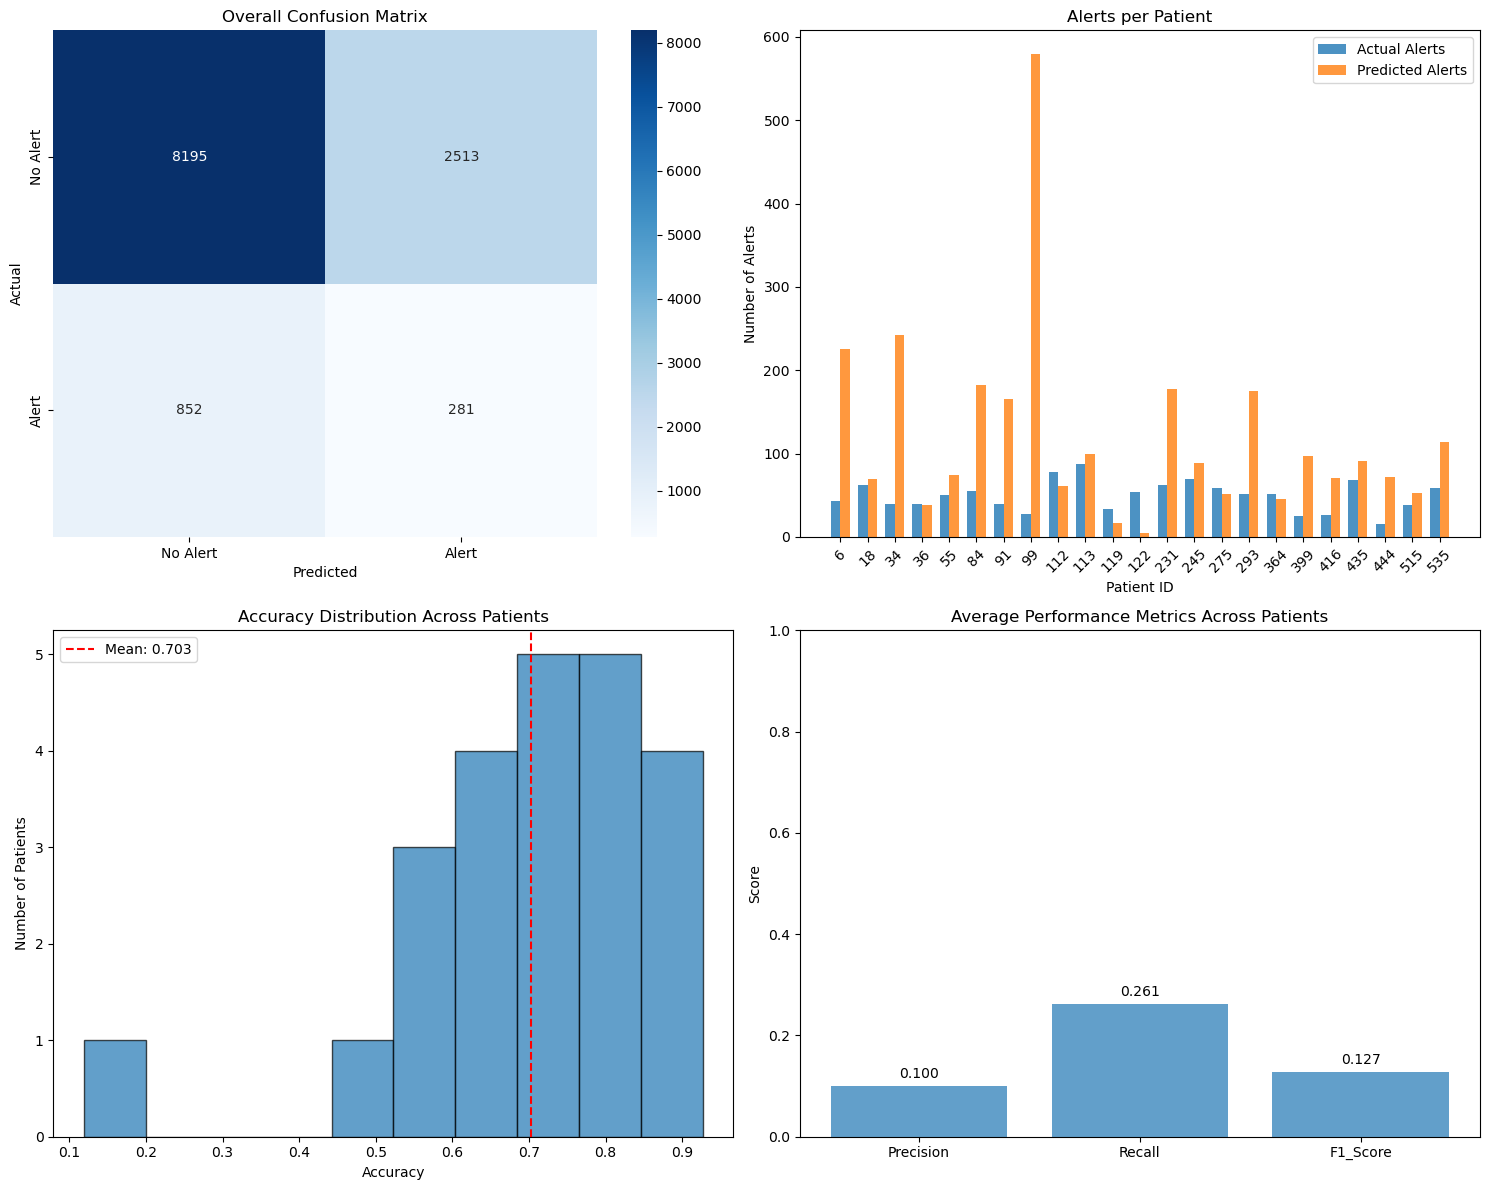


GLUCOSE PREDICTION ANALYSIS
Glucose Prediction Metrics:
Mean Squared Error (MSE): 3358.52
Mean Absolute Error (MAE): 43.82
Root Mean Squared Error (RMSE): 57.95


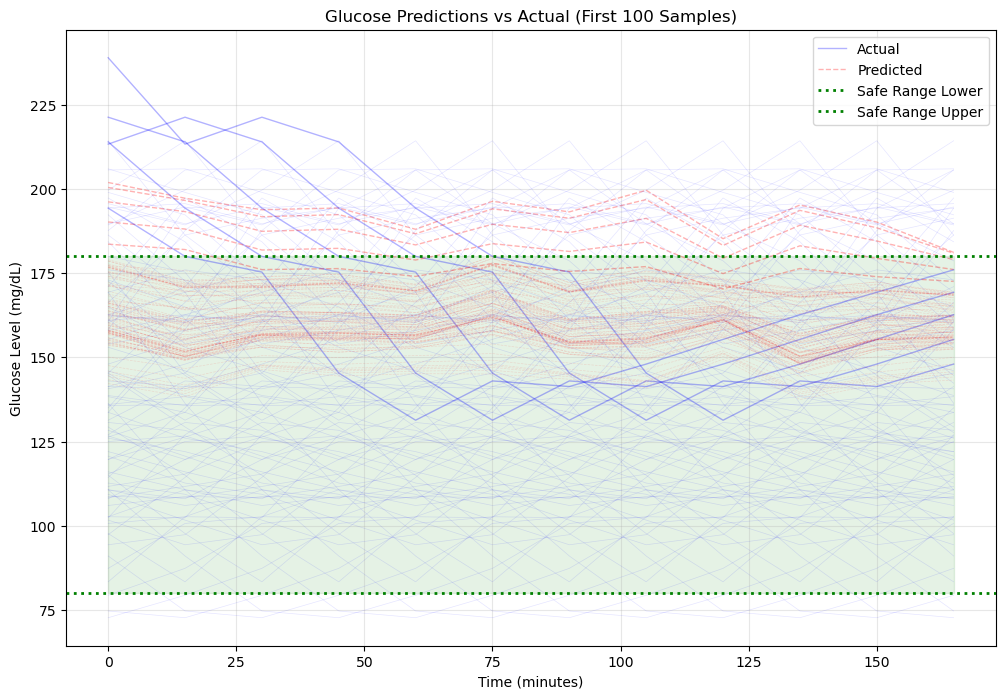


SUMMARY
• Total patients analyzed: 23
• Total test sequences: 11841
• Overall alert system accuracy: 71.6%
• Average patient-level accuracy: 70.3%
• Patients with perfect accuracy: 0
• True positive rate (sensitivity): 2.4%
• False positive rate: 21.2%
• True negative rate (specificity): 69.2%
• False negative rate: 7.2%


In [46]:
def generate_alert_label(glucose_array, safe_range=(80, 180), threshold=1/3):
    """
    Generate alert label based on glucose values outside safe range
    
    Args:
        glucose_array: Array of glucose values
        safe_range: Tuple of (min, max) safe glucose values
        threshold: Fraction of values that need to be outside range to trigger alert
    
    Returns:
        1 if alert needed, 0 if no alert
    """
    # Count values outside safe range
    outside_range = np.sum((glucose_array < safe_range[0]) | (glucose_array > safe_range[1]))
    total_values = len(glucose_array)
    
    # Return 1 if more than threshold fraction are outside range
    return 1 if (outside_range / total_values) > threshold else 0

def create_alert_labels_for_test_data(test_data, features, seq_length, slide_step, glucose_prediction_length):
    """
    Create alert labels for test data based on actual glucose values
    Uses the SAME filtering logic as the original create_sequences function
    """
    alert_labels = []
    glucose_sequences = []
    patient_ids = []
    sequence_indices = []
    
    for patient_id in test_data['index'].unique():
        patient_data = test_data[test_data['index'] == patient_id].sort_values(by='measure_sequence')
        
        seq_count = 0
        for start in range(0, len(patient_data) - seq_length, slide_step):
            # Get the actual glucose values for the next prediction period
            next_hour_glucose = patient_data.iloc[start + seq_length:start + seq_length + glucose_prediction_length]['Glucose'].values
            
            if len(next_hour_glucose) == glucose_prediction_length:
                # Apply the SAME filtering logic as in the original create_sequences function
                # Only include sequences where more than 50% of glucose values are in stable range [80, 180]
                num_in_range = np.sum((next_hour_glucose >= 80) & (next_hour_glucose <= 180))
                if num_in_range > glucose_prediction_length * 0.5:
                    # Generate alert label based on actual glucose values
                    alert_label = generate_alert_label(next_hour_glucose)
                    alert_labels.append(alert_label)
                    glucose_sequences.append(next_hour_glucose)
                    patient_ids.append(patient_id)
                    sequence_indices.append(seq_count)
                    seq_count += 1
    
    return np.array(alert_labels), np.array(glucose_sequences), np.array(patient_ids), np.array(sequence_indices)

# Create alert labels for test data based on actual glucose values
print("Creating alert labels for test data...")
actual_alert_labels, actual_glucose_sequences, test_patient_ids, test_sequence_indices = create_alert_labels_for_test_data(
    test_data, features, seq_length=historical_time_window, 
    slide_step=sliding_window, glucose_prediction_length=glucose_time_window
)

print(f"Created {len(actual_alert_labels)} alert labels for test data")
print(f"Alert distribution - No Alert: {np.sum(actual_alert_labels == 0)}, Alert: {np.sum(actual_alert_labels == 1)}")

def make_predictions_and_generate_alerts(model, test_sequences, glucose_scaler):
    """
    Make predictions using the model and generate alerts from predictions
    """
    # Make predictions
    print("Making predictions...")
    insulin_pred, dietary_pred, activity_pred, glucose_pred = model.predict(test_sequences, verbose=1)
    
    # Inverse transform glucose predictions to original scale
    glucose_pred_original = glucose_scaler.inverse_transform(
        glucose_pred.reshape(-1, 1)).reshape(-1, glucose_time_window)
    
    # Generate alert labels from predictions
    predicted_alert_labels = []
    for glucose_seq in glucose_pred_original:
        alert_label = generate_alert_label(glucose_seq)
        predicted_alert_labels.append(alert_label)
    
    return np.array(predicted_alert_labels), glucose_pred_original

# Make predictions and generate alerts
predicted_alert_labels, predicted_glucose = make_predictions_and_generate_alerts(
    model, ts_sequences, glucose_scaler)

print(f"Generated {len(predicted_alert_labels)} predicted alert labels")
print(f"Predicted alert distribution - No Alert: {np.sum(predicted_alert_labels == 0)}, Alert: {np.sum(predicted_alert_labels == 1)}")

# Verify that we have matching array lengths
print(f"\nVerifying array lengths:")
print(f"Actual alert labels: {len(actual_alert_labels)}")
print(f"Predicted alert labels: {len(predicted_alert_labels)}")
print(f"Test patient IDs: {len(test_patient_ids)}")
print(f"Test sequences: {len(ts_sequences)}")

# Make sure all arrays have the same length
min_length = min(len(actual_alert_labels), len(predicted_alert_labels), len(test_patient_ids))
if len(actual_alert_labels) != len(predicted_alert_labels):
    print(f"\nWarning: Array length mismatch detected!")
    print(f"Truncating all arrays to minimum length: {min_length}")
    actual_alert_labels = actual_alert_labels[:min_length]
    predicted_alert_labels = predicted_alert_labels[:min_length]
    test_patient_ids = test_patient_ids[:min_length]
    test_sequence_indices = test_sequence_indices[:min_length]
    
print(f"Final array lengths after adjustment:")
print(f"Actual alert labels: {len(actual_alert_labels)}")
print(f"Predicted alert labels: {len(predicted_alert_labels)}")
print(f"Test patient IDs: {len(test_patient_ids)}")
print(f"Test sequence indices: {len(test_sequence_indices)}")

def calculate_alert_metrics(actual_alerts, predicted_alerts):
    """
    Calculate performance metrics for alert system
    """
    # Ensure arrays have the same length
    if len(actual_alerts) != len(predicted_alerts):
        min_len = min(len(actual_alerts), len(predicted_alerts))
        print(f"Warning: Truncating arrays to length {min_len} for metrics calculation")
        actual_alerts = actual_alerts[:min_len]
        predicted_alerts = predicted_alerts[:min_len]
    
    # Handle edge case where all predictions are the same class
    unique_actual = np.unique(actual_alerts)
    unique_predicted = np.unique(predicted_alerts)
    
    print(f"Unique values in actual alerts: {unique_actual}")
    print(f"Unique values in predicted alerts: {unique_predicted}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(actual_alerts, predicted_alerts)
    print(f"Confusion matrix shape: {cm.shape}")
    print(f"Confusion matrix:\n{cm}")
    
    # Handle different confusion matrix sizes
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1):
        # Only one class present
        if unique_actual[0] == 0 and unique_predicted[0] == 0:
            tn, fp, fn, tp = cm[0,0], 0, 0, 0
        else:
            tn, fp, fn, tp = 0, 0, 0, cm[0,0]
    else:
        # Fallback for unexpected shapes
        tn = cm[0,0] if cm.shape[0] > 0 and cm.shape[1] > 0 else 0
        fp = cm[0,1] if cm.shape[0] > 0 and cm.shape[1] > 1 else 0
        fn = cm[1,0] if cm.shape[0] > 1 and cm.shape[1] > 0 else 0
        tp = cm[1,1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
    
    # Calculate metrics
    accuracy = accuracy_score(actual_alerts, predicted_alerts)
    precision = precision_score(actual_alerts, predicted_alerts, zero_division=0)
    recall = recall_score(actual_alerts, predicted_alerts, zero_division=0)
    f1 = f1_score(actual_alerts, predicted_alerts, zero_division=0)
    
    # Calculate rates
    total = len(actual_alerts)
    tp_rate = tp / total if total > 0 else 0  # True Positive Rate
    fp_rate = fp / total if total > 0 else 0  # False Positive Rate  
    fn_rate = fn / total if total > 0 else 0  # False Negative Rate
    tn_rate = tn / total if total > 0 else 0  # True Negative Rate
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'true_positive': int(tp),
        'false_positive': int(fp),
        'false_negative': int(fn),
        'true_negative': int(tn),
        'tp_rate': tp_rate,
        'fp_rate': fp_rate,
        'fn_rate': fn_rate,
        'tn_rate': tn_rate,
        'total_samples': total
    }
    
    return metrics

def analyze_patient_alerts(patient_ids, sequence_indices, actual_alerts, predicted_alerts):
    """
    Analyze alerts on a per-patient basis
    """
    # Ensure all arrays have the same length
    min_length = min(len(patient_ids), len(actual_alerts), len(predicted_alerts))
    if not all(len(arr) == min_length for arr in [patient_ids, actual_alerts, predicted_alerts]):
        print(f"Adjusting arrays to minimum length: {min_length}")
        patient_ids = patient_ids[:min_length]
        sequence_indices = sequence_indices[:min_length]
        actual_alerts = actual_alerts[:min_length]
        predicted_alerts = predicted_alerts[:min_length]
    
    patient_results = {}
    unique_patients = np.unique(patient_ids)
    
    for patient_id in unique_patients:
        # Get indices for this patient
        patient_mask = patient_ids == patient_id
        
        # Get alerts for this patient
        patient_actual = actual_alerts[patient_mask]
        patient_predicted = predicted_alerts[patient_mask]
        
        # Calculate metrics for this patient
        if len(patient_actual) > 0 and len(patient_predicted) > 0:
            try:
                patient_metrics = calculate_alert_metrics(patient_actual, patient_predicted)
                patient_results[patient_id] = {
                    'metrics': patient_metrics,
                    'num_sequences': len(patient_actual),
                    'actual_alerts': patient_actual,
                    'predicted_alerts': patient_predicted
                }
            except Exception as e:
                print(f"Error calculating metrics for patient {patient_id}: {e}")
                # Create default metrics
                patient_results[patient_id] = {
                    'metrics': {
                        'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0,
                        'true_positive': 0, 'false_positive': 0, 'false_negative': 0, 'true_negative': 0,
                        'tp_rate': 0.0, 'fp_rate': 0.0, 'fn_rate': 0.0, 'tn_rate': 0.0,
                        'total_samples': len(patient_actual)
                    },
                    'num_sequences': len(patient_actual),
                    'actual_alerts': patient_actual,
                    'predicted_alerts': patient_predicted
                }
    
    return patient_results

# Calculate overall metrics
print("\n" + "="*60)
print("OVERALL ALERT SYSTEM PERFORMANCE")
print("="*60)

overall_metrics = calculate_alert_metrics(actual_alert_labels, predicted_alert_labels)

print(f"Total test samples: {overall_metrics['total_samples']}")
print(f"Accuracy: {overall_metrics['accuracy']:.4f}")
print(f"Precision: {overall_metrics['precision']:.4f}")
print(f"Recall: {overall_metrics['recall']:.4f}")
print(f"F1-Score: {overall_metrics['f1_score']:.4f}")
print()
print("Confusion Matrix:")
print(f"True Positive (Correct Alerts): {overall_metrics['true_positive']} ({overall_metrics['tp_rate']:.4f})")
print(f"False Positive (False Alerts): {overall_metrics['false_positive']} ({overall_metrics['fp_rate']:.4f})")
print(f"False Negative (Missed Alerts): {overall_metrics['false_negative']} ({overall_metrics['fn_rate']:.4f})")
print(f"True Negative (Correct No-Alerts): {overall_metrics['true_negative']} ({overall_metrics['tn_rate']:.4f})")

# Analyze per-patient results
print("\n" + "="*60)
print("PER-PATIENT ALERT ANALYSIS")
print("="*60)

patient_results = analyze_patient_alerts(test_patient_ids, test_sequence_indices, 
                                       actual_alert_labels, predicted_alert_labels)

# Summary statistics per patient
patient_summary = []
for patient_id, results in patient_results.items():
    metrics = results['metrics']
    num_sequences = results['num_sequences']
    total_actual_alerts = np.sum(results['actual_alerts'])
    total_predicted_alerts = np.sum(results['predicted_alerts'])
    
    patient_summary.append({
        'Patient_ID': patient_id,
        'Num_Sequences': num_sequences,
        'Actual_Alerts': total_actual_alerts,
        'Predicted_Alerts': total_predicted_alerts,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1_Score': metrics['f1_score'],
        'TP': metrics['true_positive'],
        'FP': metrics['false_positive'],
        'FN': metrics['false_negative'],
        'TN': metrics['true_negative']
    })

# Convert to DataFrame for easy viewing
patient_summary_df = pd.DataFrame(patient_summary)
print("\nPatient Summary:")
print(patient_summary_df.to_string(index=False))

# Show detailed results for first few patients
print("\n" + "="*60)
print("DETAILED RESULTS FOR FIRST 5 PATIENTS")
print("="*60)

for i, (patient_id, results) in enumerate(list(patient_results.items())[:5]):
    print(f"\nPatient {patient_id}:")
    print(f"  Number of sequences: {results['num_sequences']}")
    print(f"  Actual alerts: {np.sum(results['actual_alerts'])}/{len(results['actual_alerts'])}")
    print(f"  Predicted alerts: {np.sum(results['predicted_alerts'])}/{len(results['predicted_alerts'])}")
    print(f"  Accuracy: {results['metrics']['accuracy']:.4f}")
    print(f"  True Positives: {results['metrics']['true_positive']}")
    print(f"  False Positives: {results['metrics']['false_positive']}")
    print(f"  False Negatives: {results['metrics']['false_negative']}")
    print(f"  True Negatives: {results['metrics']['true_negative']}")

def plot_alert_analysis():
    """
    Create visualizations for alert analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Overall confusion matrix
    cm = confusion_matrix(actual_alert_labels, predicted_alert_labels)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[0,0], cmap='Blues',
                xticklabels=['No Alert', 'Alert'], yticklabels=['No Alert', 'Alert'])
    axes[0,0].set_title('Overall Confusion Matrix')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')
    
    # 2. Alert distribution by patient
    patient_alert_counts = patient_summary_df[['Patient_ID', 'Actual_Alerts', 'Predicted_Alerts']]
    x = np.arange(len(patient_alert_counts))
    width = 0.35
    
    axes[0,1].bar(x - width/2, patient_alert_counts['Actual_Alerts'], width, 
                  label='Actual Alerts', alpha=0.8)
    axes[0,1].bar(x + width/2, patient_alert_counts['Predicted_Alerts'], width, 
                  label='Predicted Alerts', alpha=0.8)
    axes[0,1].set_xlabel('Patient ID')
    axes[0,1].set_ylabel('Number of Alerts')
    axes[0,1].set_title('Alerts per Patient')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(patient_alert_counts['Patient_ID'], rotation=45)
    axes[0,1].legend()
    
    # 3. Accuracy distribution across patients
    axes[1,0].hist(patient_summary_df['Accuracy'], bins=10, edgecolor='black', alpha=0.7)
    axes[1,0].set_xlabel('Accuracy')
    axes[1,0].set_ylabel('Number of Patients')
    axes[1,0].set_title('Accuracy Distribution Across Patients')
    axes[1,0].axvline(patient_summary_df['Accuracy'].mean(), color='red', 
                      linestyle='--', label=f'Mean: {patient_summary_df["Accuracy"].mean():.3f}')
    axes[1,0].legend()
    
    # 4. Performance metrics comparison
    metrics_names = ['Precision', 'Recall', 'F1_Score']
    metrics_values = [patient_summary_df[metric].mean() for metric in metrics_names]
    
    axes[1,1].bar(metrics_names, metrics_values, alpha=0.7)
    axes[1,1].set_ylabel('Score')
    axes[1,1].set_title('Average Performance Metrics Across Patients')
    axes[1,1].set_ylim(0, 1)
    
    # Add value labels on bars
    for i, v in enumerate(metrics_values):
        axes[1,1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Create visualizations
plot_alert_analysis()

def analyze_glucose_predictions_vs_actual():
    """
    Compare predicted glucose values vs actual glucose values
    """
    print("\n" + "="*60)
    print("GLUCOSE PREDICTION ANALYSIS")
    print("="*60)
    
    # Convert actual glucose sequences back to original scale for comparison
    actual_glucose_original = glucose_scaler.inverse_transform(
        ts_glucose_targets.reshape(-1, 1)).reshape(-1, glucose_time_window)
    
    # Calculate glucose prediction metrics
    mse = np.mean((actual_glucose_original - predicted_glucose) ** 2)
    mae = np.mean(np.abs(actual_glucose_original - predicted_glucose))
    rmse = np.sqrt(mse)
    
    print(f"Glucose Prediction Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    
    # Plot glucose predictions vs actual
    plt.figure(figsize=(12, 8))
    
    # Plot first 100 samples for clarity
    n_samples = min(100, len(actual_glucose_original))
    time_points = np.arange(glucose_time_window) * 15  # 15-minute intervals
    
    for i in range(n_samples):
        if i < 5:  # Show only first 5 for legend clarity
            plt.plot(time_points, actual_glucose_original[i], 'b-', alpha=0.3, 
                    label='Actual' if i == 0 else "", linewidth=1)
            plt.plot(time_points, predicted_glucose[i], 'r--', alpha=0.3, 
                    label='Predicted' if i == 0 else "", linewidth=1)
        else:
            plt.plot(time_points, actual_glucose_original[i], 'b-', alpha=0.1, linewidth=0.5)
            plt.plot(time_points, predicted_glucose[i], 'r--', alpha=0.1, linewidth=0.5)
    
    # Add safe range
    plt.axhline(y=80, color='green', linestyle=':', label='Safe Range Lower', linewidth=2)
    plt.axhline(y=180, color='green', linestyle=':', label='Safe Range Upper', linewidth=2)
    plt.fill_between(time_points, 80, 180, alpha=0.1, color='green')
    
    plt.xlabel('Time (minutes)')
    plt.ylabel('Glucose Level (mg/dL)')
    plt.title(f'Glucose Predictions vs Actual (First {n_samples} Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Analyze glucose predictions
analyze_glucose_predictions_vs_actual()

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"• Total patients analyzed: {len(patient_results)}")
print(f"• Total test sequences: {len(actual_alert_labels)}")
print(f"• Overall alert system accuracy: {overall_metrics['accuracy']:.1%}")
print(f"• Average patient-level accuracy: {patient_summary_df['Accuracy'].mean():.1%}")
print(f"• Patients with perfect accuracy: {np.sum(patient_summary_df['Accuracy'] == 1.0)}")
print(f"• True positive rate (sensitivity): {overall_metrics['tp_rate']:.1%}")
print(f"• False positive rate: {overall_metrics['fp_rate']:.1%}")
print(f"• True negative rate (specificity): {overall_metrics['tn_rate']:.1%}")
print(f"• False negative rate: {overall_metrics['fn_rate']:.1%}")

Creating alert labels for test data...
Created 11841 alert labels for test data
Alert distribution - No Alert: 10708, Alert: 1133
Making predictions...
613/613 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step
Generated 19596 predicted alert labels
Predicted alert distribution - No Alert: 15590, Alert: 4006

Verifying array lengths:
Actual alert labels: 11841
Predicted alert labels: 19596
Test patient IDs: 11841
Test sequences: 19596

Truncating all arrays to minimum length: 11841
Final array lengths after adjustment:
Actual alert labels: 11841
Predicted alert labels: 11841
Test patient IDs: 11841
Test sequence indices: 11841

OVERALL ALERT SYSTEM PERFORMANCE
Unique values in actual alerts: [0 1]
Unique values in predicted alerts: [0 1]
Confusion matrix shape: (2, 2)
Confusion matrix:
[[8195 2513]
 [ 852  281]]
Total test samples: 11841
Accuracy: 0.7158
Precision: 0.1006
Recall: 0.2480
F1-Score: 0.1431

Confusion Matrix:
True Positive (Correct Alerts): 281 (0.0237)
False Positive (False Alerts): 2513

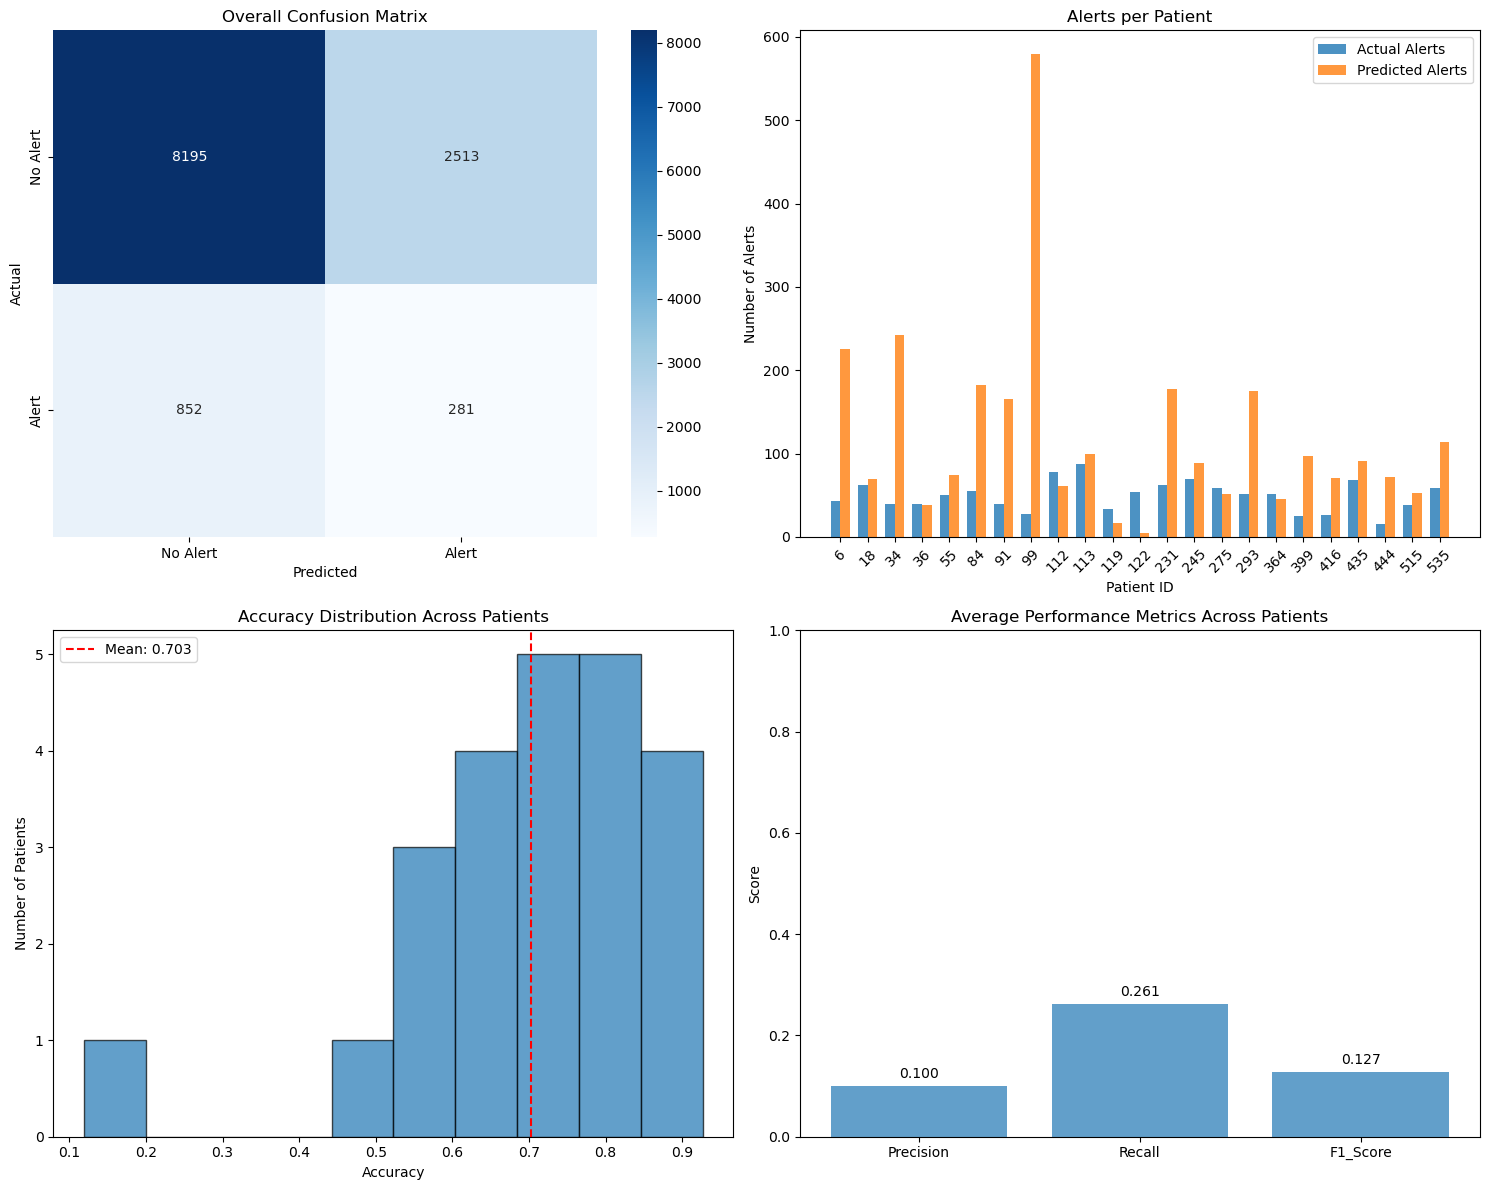


GLUCOSE PREDICTION ANALYSIS
Glucose Prediction Metrics:
Mean Squared Error (MSE): 3358.52
Mean Absolute Error (MAE): 43.82
Root Mean Squared Error (RMSE): 57.95


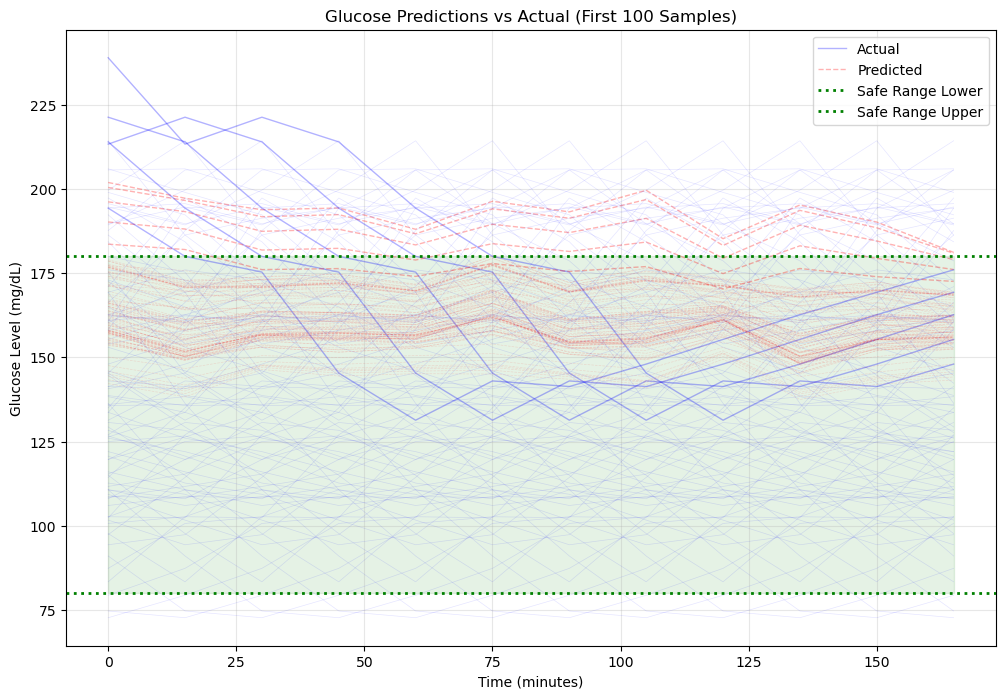


SUMMARY
• Total patients analyzed: 23
• Total test sequences: 11841
• Overall alert system accuracy: 71.6%
• Average patient-level accuracy: 70.3%
• Patients with perfect accuracy: 0
• True positive rate (sensitivity): 2.4%
• False positive rate: 21.2%
• True negative rate (specificity): 69.2%
• False negative rate: 7.2%
Average alerts per patient: 121.48


In [49]:
def generate_alert_label(glucose_array, safe_range=(80, 180), threshold=1/3):
    """
    Generate alert label based on glucose values outside safe range
    
    Args:
        glucose_array: Array of glucose values
        safe_range: Tuple of (min, max) safe glucose values
        threshold: Fraction of values that need to be outside range to trigger alert
    
    Returns:
        1 if alert needed, 0 if no alert
    """
    # Count values outside safe range
    outside_range = np.sum((glucose_array < safe_range[0]) | (glucose_array > safe_range[1]))
    total_values = len(glucose_array)
    
    # Return 1 if more than threshold fraction are outside range
    return 1 if (outside_range / total_values) > threshold else 0

def create_alert_labels_for_test_data(test_data, features, seq_length, slide_step, glucose_prediction_length):
    """
    Create alert labels for test data based on actual glucose values
    Uses the SAME filtering logic as the original create_sequences function
    """
    alert_labels = []
    glucose_sequences = []
    patient_ids = []
    sequence_indices = []
    
    for patient_id in test_data['index'].unique():
        patient_data = test_data[test_data['index'] == patient_id].sort_values(by='measure_sequence')
        
        seq_count = 0
        for start in range(0, len(patient_data) - seq_length, slide_step):
            # Get the actual glucose values for the next prediction period
            next_hour_glucose = patient_data.iloc[start + seq_length:start + seq_length + glucose_prediction_length]['Glucose'].values
            
            if len(next_hour_glucose) == glucose_prediction_length:
                # Apply the SAME filtering logic as in the original create_sequences function
                # Only include sequences where more than 50% of glucose values are in stable range [80, 180]
                num_in_range = np.sum((next_hour_glucose >= 80) & (next_hour_glucose <= 180))
                if num_in_range > glucose_prediction_length * 0.5:
                    # Generate alert label based on actual glucose values
                    alert_label = generate_alert_label(next_hour_glucose)
                    alert_labels.append(alert_label)
                    glucose_sequences.append(next_hour_glucose)
                    patient_ids.append(patient_id)
                    sequence_indices.append(seq_count)
                    seq_count += 1
    
    return np.array(alert_labels), np.array(glucose_sequences), np.array(patient_ids), np.array(sequence_indices)

# Create alert labels for test data based on actual glucose values
print("Creating alert labels for test data...")
actual_alert_labels, actual_glucose_sequences, test_patient_ids, test_sequence_indices = create_alert_labels_for_test_data(
    test_data, features, seq_length=historical_time_window, 
    slide_step=sliding_window, glucose_prediction_length=glucose_time_window
)

print(f"Created {len(actual_alert_labels)} alert labels for test data")
print(f"Alert distribution - No Alert: {np.sum(actual_alert_labels == 0)}, Alert: {np.sum(actual_alert_labels == 1)}")

def make_predictions_and_generate_alerts(model, test_sequences, glucose_scaler):
    """
    Make predictions using the model and generate alerts from predictions
    """
    # Make predictions
    print("Making predictions...")
    insulin_pred, dietary_pred, activity_pred, glucose_pred = model.predict(test_sequences, verbose=1)
    
    # Inverse transform glucose predictions to original scale
    glucose_pred_original = glucose_scaler.inverse_transform(
        glucose_pred.reshape(-1, 1)).reshape(-1, glucose_time_window)
    
    # Generate alert labels from predictions
    predicted_alert_labels = []
    for glucose_seq in glucose_pred_original:
        alert_label = generate_alert_label(glucose_seq)
        predicted_alert_labels.append(alert_label)
    
    return np.array(predicted_alert_labels), glucose_pred_original

# Make predictions and generate alerts
predicted_alert_labels, predicted_glucose = make_predictions_and_generate_alerts(
    model, ts_sequences, glucose_scaler)

print(f"Generated {len(predicted_alert_labels)} predicted alert labels")
print(f"Predicted alert distribution - No Alert: {np.sum(predicted_alert_labels == 0)}, Alert: {np.sum(predicted_alert_labels == 1)}")

# Verify that we have matching array lengths
print(f"\nVerifying array lengths:")
print(f"Actual alert labels: {len(actual_alert_labels)}")
print(f"Predicted alert labels: {len(predicted_alert_labels)}")
print(f"Test patient IDs: {len(test_patient_ids)}")
print(f"Test sequences: {len(ts_sequences)}")

# Make sure all arrays have the same length
min_length = min(len(actual_alert_labels), len(predicted_alert_labels), len(test_patient_ids))
if len(actual_alert_labels) != len(predicted_alert_labels):
    print(f"\nWarning: Array length mismatch detected!")
    print(f"Truncating all arrays to minimum length: {min_length}")
    actual_alert_labels = actual_alert_labels[:min_length]
    predicted_alert_labels = predicted_alert_labels[:min_length]
    test_patient_ids = test_patient_ids[:min_length]
    test_sequence_indices = test_sequence_indices[:min_length]
    
print(f"Final array lengths after adjustment:")
print(f"Actual alert labels: {len(actual_alert_labels)}")
print(f"Predicted alert labels: {len(predicted_alert_labels)}")
print(f"Test patient IDs: {len(test_patient_ids)}")
print(f"Test sequence indices: {len(test_sequence_indices)}")

def calculate_alert_metrics(actual_alerts, predicted_alerts):
    """
    Calculate performance metrics for alert system
    """
    # Ensure arrays have the same length
    if len(actual_alerts) != len(predicted_alerts):
        min_len = min(len(actual_alerts), len(predicted_alerts))
        print(f"Warning: Truncating arrays to length {min_len} for metrics calculation")
        actual_alerts = actual_alerts[:min_len]
        predicted_alerts = predicted_alerts[:min_len]
    
    # Handle edge case where all predictions are the same class
    unique_actual = np.unique(actual_alerts)
    unique_predicted = np.unique(predicted_alerts)
    
    print(f"Unique values in actual alerts: {unique_actual}")
    print(f"Unique values in predicted alerts: {unique_predicted}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(actual_alerts, predicted_alerts)
    print(f"Confusion matrix shape: {cm.shape}")
    print(f"Confusion matrix:\n{cm}")
    
    # Handle different confusion matrix sizes
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1):
        # Only one class present
        if unique_actual[0] == 0 and unique_predicted[0] == 0:
            tn, fp, fn, tp = cm[0,0], 0, 0, 0
        else:
            tn, fp, fn, tp = 0, 0, 0, cm[0,0]
    else:
        # Fallback for unexpected shapes
        tn = cm[0,0] if cm.shape[0] > 0 and cm.shape[1] > 0 else 0
        fp = cm[0,1] if cm.shape[0] > 0 and cm.shape[1] > 1 else 0
        fn = cm[1,0] if cm.shape[0] > 1 and cm.shape[1] > 0 else 0
        tp = cm[1,1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
    
    # Calculate metrics
    accuracy = accuracy_score(actual_alerts, predicted_alerts)
    precision = precision_score(actual_alerts, predicted_alerts, zero_division=0)
    recall = recall_score(actual_alerts, predicted_alerts, zero_division=0)
    f1 = f1_score(actual_alerts, predicted_alerts, zero_division=0)
    
    # Calculate rates
    total = len(actual_alerts)
    tp_rate = tp / total if total > 0 else 0  # True Positive Rate
    fp_rate = fp / total if total > 0 else 0  # False Positive Rate  
    fn_rate = fn / total if total > 0 else 0  # False Negative Rate
    tn_rate = tn / total if total > 0 else 0  # True Negative Rate
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'true_positive': int(tp),
        'false_positive': int(fp),
        'false_negative': int(fn),
        'true_negative': int(tn),
        'tp_rate': tp_rate,
        'fp_rate': fp_rate,
        'fn_rate': fn_rate,
        'tn_rate': tn_rate,
        'total_samples': total
    }
    
    return metrics

def analyze_patient_alerts(patient_ids, sequence_indices, actual_alerts, predicted_alerts):
    """
    Analyze alerts on a per-patient basis
    """
    # Ensure all arrays have the same length
    min_length = min(len(patient_ids), len(actual_alerts), len(predicted_alerts))
    if not all(len(arr) == min_length for arr in [patient_ids, actual_alerts, predicted_alerts]):
        print(f"Adjusting arrays to minimum length: {min_length}")
        patient_ids = patient_ids[:min_length]
        sequence_indices = sequence_indices[:min_length]
        actual_alerts = actual_alerts[:min_length]
        predicted_alerts = predicted_alerts[:min_length]
    
    patient_results = {}
    unique_patients = np.unique(patient_ids)
    
    for patient_id in unique_patients:
        # Get indices for this patient
        patient_mask = patient_ids == patient_id
        
        # Get alerts for this patient
        patient_actual = actual_alerts[patient_mask]
        patient_predicted = predicted_alerts[patient_mask]
        
        # Calculate metrics for this patient
        if len(patient_actual) > 0 and len(patient_predicted) > 0:
            try:
                patient_metrics = calculate_alert_metrics(patient_actual, patient_predicted)
                patient_results[patient_id] = {
                    'metrics': patient_metrics,
                    'num_sequences': len(patient_actual),
                    'actual_alerts': patient_actual,
                    'predicted_alerts': patient_predicted
                }
            except Exception as e:
                print(f"Error calculating metrics for patient {patient_id}: {e}")
                # Create default metrics
                patient_results[patient_id] = {
                    'metrics': {
                        'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0,
                        'true_positive': 0, 'false_positive': 0, 'false_negative': 0, 'true_negative': 0,
                        'tp_rate': 0.0, 'fp_rate': 0.0, 'fn_rate': 0.0, 'tn_rate': 0.0,
                        'total_samples': len(patient_actual)
                    },
                    'num_sequences': len(patient_actual),
                    'actual_alerts': patient_actual,
                    'predicted_alerts': patient_predicted
                }
    
    return patient_results

# Calculate overall metrics
print("\n" + "="*60)
print("OVERALL ALERT SYSTEM PERFORMANCE")
print("="*60)

overall_metrics = calculate_alert_metrics(actual_alert_labels, predicted_alert_labels)

print(f"Total test samples: {overall_metrics['total_samples']}")
print(f"Accuracy: {overall_metrics['accuracy']:.4f}")
print(f"Precision: {overall_metrics['precision']:.4f}")
print(f"Recall: {overall_metrics['recall']:.4f}")
print(f"F1-Score: {overall_metrics['f1_score']:.4f}")
print()
print("Confusion Matrix:")
print(f"True Positive (Correct Alerts): {overall_metrics['true_positive']} ({overall_metrics['tp_rate']:.4f})")
print(f"False Positive (False Alerts): {overall_metrics['false_positive']} ({overall_metrics['fp_rate']:.4f})")
print(f"False Negative (Missed Alerts): {overall_metrics['false_negative']} ({overall_metrics['fn_rate']:.4f})")
print(f"True Negative (Correct No-Alerts): {overall_metrics['true_negative']} ({overall_metrics['tn_rate']:.4f})")

# Analyze per-patient results
print("\n" + "="*60)
print("PER-PATIENT ALERT ANALYSIS")
print("="*60)

patient_results = analyze_patient_alerts(test_patient_ids, test_sequence_indices, 
                                       actual_alert_labels, predicted_alert_labels)

# Summary statistics per patient
patient_summary = []
for patient_id, results in patient_results.items():
    metrics = results['metrics']
    num_sequences = results['num_sequences']
    total_actual_alerts = np.sum(results['actual_alerts'])
    total_predicted_alerts = np.sum(results['predicted_alerts'])
    
    patient_summary.append({
        'Patient_ID': patient_id,
        'Num_Sequences': num_sequences,
        'Actual_Alerts': total_actual_alerts,
        'Predicted_Alerts': total_predicted_alerts,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1_Score': metrics['f1_score'],
        'TP': metrics['true_positive'],
        'FP': metrics['false_positive'],
        'FN': metrics['false_negative'],
        'TN': metrics['true_negative']
    })

# Convert to DataFrame for easy viewing
patient_summary_df = pd.DataFrame(patient_summary)
print("\nPatient Summary:")
print(patient_summary_df.to_string(index=False))

# Show detailed results for first few patients
print("\n" + "="*60)
print("DETAILED RESULTS FOR FIRST 5 PATIENTS")
print("="*60)

for i, (patient_id, results) in enumerate(list(patient_results.items())[:5]):
    print(f"\nPatient {patient_id}:")
    print(f"  Number of sequences: {results['num_sequences']}")
    print(f"  Actual alerts: {np.sum(results['actual_alerts'])}/{len(results['actual_alerts'])}")
    print(f"  Predicted alerts: {np.sum(results['predicted_alerts'])}/{len(results['predicted_alerts'])}")
    print(f"  Accuracy: {results['metrics']['accuracy']:.4f}")
    print(f"  True Positives: {results['metrics']['true_positive']}")
    print(f"  False Positives: {results['metrics']['false_positive']}")
    print(f"  False Negatives: {results['metrics']['false_negative']}")
    print(f"  True Negatives: {results['metrics']['true_negative']}")

def plot_alert_analysis():
    """
    Create visualizations for alert analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Overall confusion matrix
    cm = confusion_matrix(actual_alert_labels, predicted_alert_labels)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[0,0], cmap='Blues',
                xticklabels=['No Alert', 'Alert'], yticklabels=['No Alert', 'Alert'])
    axes[0,0].set_title('Overall Confusion Matrix')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')
    
    # 2. Alert distribution by patient
    patient_alert_counts = patient_summary_df[['Patient_ID', 'Actual_Alerts', 'Predicted_Alerts']]
    x = np.arange(len(patient_alert_counts))
    width = 0.35
    
    axes[0,1].bar(x - width/2, patient_alert_counts['Actual_Alerts'], width, 
                  label='Actual Alerts', alpha=0.8)
    axes[0,1].bar(x + width/2, patient_alert_counts['Predicted_Alerts'], width, 
                  label='Predicted Alerts', alpha=0.8)
    axes[0,1].set_xlabel('Patient ID')
    axes[0,1].set_ylabel('Number of Alerts')
    axes[0,1].set_title('Alerts per Patient')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(patient_alert_counts['Patient_ID'], rotation=45)
    axes[0,1].legend()
    
    # 3. Accuracy distribution across patients
    axes[1,0].hist(patient_summary_df['Accuracy'], bins=10, edgecolor='black', alpha=0.7)
    axes[1,0].set_xlabel('Accuracy')
    axes[1,0].set_ylabel('Number of Patients')
    axes[1,0].set_title('Accuracy Distribution Across Patients')
    axes[1,0].axvline(patient_summary_df['Accuracy'].mean(), color='red', 
                      linestyle='--', label=f'Mean: {patient_summary_df["Accuracy"].mean():.3f}')
    axes[1,0].legend()
    
    # 4. Performance metrics comparison
    metrics_names = ['Precision', 'Recall', 'F1_Score']
    metrics_values = [patient_summary_df[metric].mean() for metric in metrics_names]
    
    axes[1,1].bar(metrics_names, metrics_values, alpha=0.7)
    axes[1,1].set_ylabel('Score')
    axes[1,1].set_title('Average Performance Metrics Across Patients')
    axes[1,1].set_ylim(0, 1)
    
    # Add value labels on bars
    for i, v in enumerate(metrics_values):
        axes[1,1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Create visualizations
plot_alert_analysis()

def analyze_glucose_predictions_vs_actual():
    """
    Compare predicted glucose values vs actual glucose values
    """
    print("\n" + "="*60)
    print("GLUCOSE PREDICTION ANALYSIS")
    print("="*60)
    
    # Convert actual glucose sequences back to original scale for comparison
    actual_glucose_original = glucose_scaler.inverse_transform(
        ts_glucose_targets.reshape(-1, 1)).reshape(-1, glucose_time_window)
    
    # Calculate glucose prediction metrics
    mse = np.mean((actual_glucose_original - predicted_glucose) ** 2)
    mae = np.mean(np.abs(actual_glucose_original - predicted_glucose))
    rmse = np.sqrt(mse)
    
    print(f"Glucose Prediction Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    
    # Plot glucose predictions vs actual
    plt.figure(figsize=(12, 8))
    
    # Plot first 100 samples for clarity
    n_samples = min(100, len(actual_glucose_original))
    time_points = np.arange(glucose_time_window) * 15  # 15-minute intervals
    
    for i in range(n_samples):
        if i < 5:  # Show only first 5 for legend clarity
            plt.plot(time_points, actual_glucose_original[i], 'b-', alpha=0.3, 
                    label='Actual' if i == 0 else "", linewidth=1)
            plt.plot(time_points, predicted_glucose[i], 'r--', alpha=0.3, 
                    label='Predicted' if i == 0 else "", linewidth=1)
        else:
            plt.plot(time_points, actual_glucose_original[i], 'b-', alpha=0.1, linewidth=0.5)
            plt.plot(time_points, predicted_glucose[i], 'r--', alpha=0.1, linewidth=0.5)
    
    # Add safe range
    plt.axhline(y=80, color='green', linestyle=':', label='Safe Range Lower', linewidth=2)
    plt.axhline(y=180, color='green', linestyle=':', label='Safe Range Upper', linewidth=2)
    plt.fill_between(time_points, 80, 180, alpha=0.1, color='green')
    
    plt.xlabel('Time (minutes)')
    plt.ylabel('Glucose Level (mg/dL)')
    plt.title(f'Glucose Predictions vs Actual (First {n_samples} Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Analyze glucose predictions
analyze_glucose_predictions_vs_actual()

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"• Total patients analyzed: {len(patient_results)}")
print(f"• Total test sequences: {len(actual_alert_labels)}")
print(f"• Overall alert system accuracy: {overall_metrics['accuracy']:.1%}")
print(f"• Average patient-level accuracy: {patient_summary_df['Accuracy'].mean():.1%}")
print(f"• Patients with perfect accuracy: {np.sum(patient_summary_df['Accuracy'] == 1.0)}")
print(f"• True positive rate (sensitivity): {overall_metrics['tp_rate']:.1%}")
print(f"• False positive rate: {overall_metrics['fp_rate']:.1%}")
print(f"• True negative rate (specificity): {overall_metrics['tn_rate']:.1%}")
print(f"• False negative rate: {overall_metrics['fn_rate']:.1%}")
avg_alerts = patient_summary_df['Predicted_Alerts'].mean()
print(f"Average alerts per patient: {avg_alerts:.2f}")

In [50]:
patient_summary_df['Predicted_Alerts'].sum()

np.int64(2794)

In [52]:
2794/11841

0.23595980069250908


ALERT RATIO ANALYSIS BY GLUCOSE LEVEL
Median glucose level across all patients: 130.0 mg/dL
High glucose patients (>130.0 mg/dL): 23
Low glucose patients (≤130.0 mg/dL): 0

HIGH GLUCOSE Group Results:
  Number of patients: 23
  Total sequences: 11841
  Total predicted alerts: 2794
  Total real alerts: 1133
  Predicted alert ratio: 0.236 (23.6%)
  Real alert ratio: 0.096 (9.6%)
  Ratio difference (predicted - real): 0.140

LOW GLUCOSE Group Results:
  Number of patients: 0
  Total sequences: 0
  Total predicted alerts: 0
  Total real alerts: 0
  Predicted alert ratio: 0.000 (0.0%)
  Real alert ratio: 0.000 (0.0%)
  Ratio difference (predicted - real): 0.000

--------------------------------------------------
GROUP COMPARISON:
--------------------------------------------------
Predicted alert ratio - High vs Low: 0.236 vs 0.000
Real alert ratio - High vs Low: 0.096 vs 0.000
Predicted ratio difference (High - Low): 0.236
Real ratio difference (High - Low): 0.096


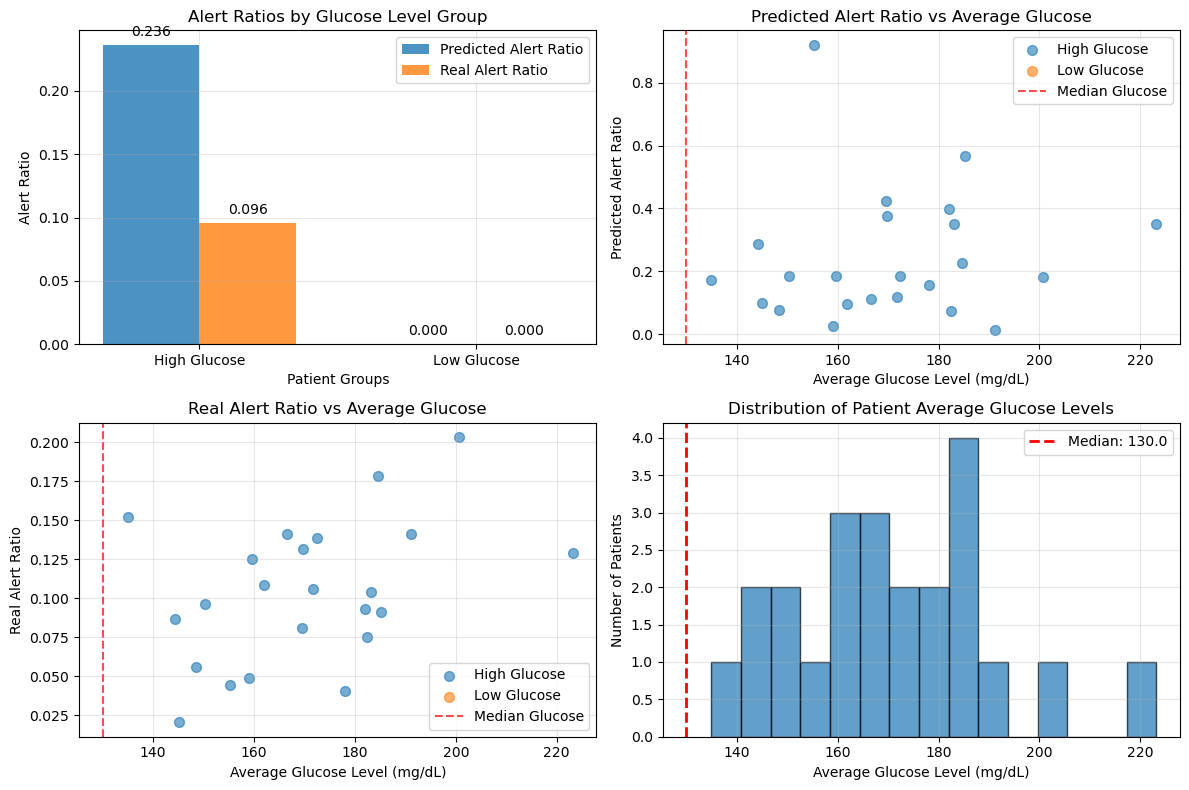


DETAILED PATIENT BREAKDOWN

HIGH GLUCOSE PATIENTS (top 5):
  Patient 416: Avg glucose=223.2, Sequences=202, Pred ratio=0.351, Real ratio=0.129
  Patient 364: Avg glucose=200.7, Sequences=251, Pred ratio=0.183, Real ratio=0.203
  Patient 122: Avg glucose=191.1, Sequences=382, Pred ratio=0.013, Real ratio=0.141
  Patient 34: Avg glucose=185.2, Sequences=427, Pred ratio=0.567, Real ratio=0.091
  Patient 245: Avg glucose=184.6, Sequences=393, Pred ratio=0.226, Real ratio=0.178

LOW GLUCOSE PATIENTS (bottom 5):


In [48]:
def analyze_alert_ratios_by_glucose_level():
    """
    Analyze alert ratios for patients with high vs low average glucose levels
    """
    print("\n" + "="*60)
    print("ALERT RATIO ANALYSIS BY GLUCOSE LEVEL")
    print("="*60)
    
    # Calculate average glucose level for each patient from the test data
    patient_glucose_averages = {}
    
    for patient_id in test_data['index'].unique():
        patient_data = test_data[test_data['index'] == patient_id]
        avg_glucose = patient_data['Glucose'].mean()
        patient_glucose_averages[patient_id] = avg_glucose
    
    # Convert to arrays for easier manipulation
    patient_ids_all = list(patient_glucose_averages.keys())
    glucose_averages = list(patient_glucose_averages.values())
    
    # Calculate median glucose level to split patients into high/low groups
    median_glucose = 130
    print(f"Median glucose level across all patients: {median_glucose:.1f} mg/dL")
    
    # Alternative: use clinical thresholds (uncomment if preferred)
    # Normal range is typically 80-140 mg/dL, so we could use 140 as threshold
    # threshold_glucose = 140
    # print(f"Using clinical threshold: {threshold_glucose} mg/dL")
    
    # Categorize patients
    high_glucose_patients = [pid for pid, avg_gluc in patient_glucose_averages.items() 
                           if avg_gluc > median_glucose]
    low_glucose_patients = [pid for pid, avg_gluc in patient_glucose_averages.items() 
                          if avg_gluc <= median_glucose]
    
    print(f"High glucose patients (>{median_glucose:.1f} mg/dL): {len(high_glucose_patients)}")
    print(f"Low glucose patients (≤{median_glucose:.1f} mg/dL): {len(low_glucose_patients)}")
    
    # Calculate alert ratios for each group
    def calculate_group_ratios(patient_group, group_name):
        group_data = {
            'total_sequences': 0,
            'predicted_alerts': 0,
            'real_alerts': 0,
            'patients': []
        }
        
        for patient_id in patient_group:
            if patient_id in patient_results:
                patient_info = patient_results[patient_id]
                num_sequences = patient_info['num_sequences']
                predicted_alerts = np.sum(patient_info['predicted_alerts'])
                real_alerts = np.sum(patient_info['actual_alerts'])
                
                group_data['total_sequences'] += num_sequences
                group_data['predicted_alerts'] += predicted_alerts
                group_data['real_alerts'] += real_alerts
                
                # Store individual patient data
                group_data['patients'].append({
                    'patient_id': patient_id,
                    'avg_glucose': patient_glucose_averages[patient_id],
                    'num_sequences': num_sequences,
                    'predicted_alerts': predicted_alerts,
                    'real_alerts': real_alerts,
                    'predicted_ratio': predicted_alerts / num_sequences if num_sequences > 0 else 0,
                    'real_ratio': real_alerts / num_sequences if num_sequences > 0 else 0
                })
        
        # Calculate group ratios
        predicted_ratio = (group_data['predicted_alerts'] / group_data['total_sequences'] 
                          if group_data['total_sequences'] > 0 else 0)
        real_ratio = (group_data['real_alerts'] / group_data['total_sequences'] 
                     if group_data['total_sequences'] > 0 else 0)
        
        print(f"\n{group_name} Group Results:")
        print(f"  Number of patients: {len(patient_group)}")
        print(f"  Total sequences: {group_data['total_sequences']}")
        print(f"  Total predicted alerts: {group_data['predicted_alerts']}")
        print(f"  Total real alerts: {group_data['real_alerts']}")
        print(f"  Predicted alert ratio: {predicted_ratio:.3f} ({predicted_ratio*100:.1f}%)")
        print(f"  Real alert ratio: {real_ratio:.3f} ({real_ratio*100:.1f}%)")
        print(f"  Ratio difference (predicted - real): {predicted_ratio - real_ratio:.3f}")
        
        return group_data, predicted_ratio, real_ratio
    
    # Analyze both groups
    high_group_data, high_pred_ratio, high_real_ratio = calculate_group_ratios(
        high_glucose_patients, "HIGH GLUCOSE")
    low_group_data, low_pred_ratio, low_real_ratio = calculate_group_ratios(
        low_glucose_patients, "LOW GLUCOSE")
    
    # Compare between groups
    print(f"\n" + "-"*50)
    print("GROUP COMPARISON:")
    print("-"*50)
    print(f"Predicted alert ratio - High vs Low: {high_pred_ratio:.3f} vs {low_pred_ratio:.3f}")
    print(f"Real alert ratio - High vs Low: {high_real_ratio:.3f} vs {low_real_ratio:.3f}")
    print(f"Predicted ratio difference (High - Low): {high_pred_ratio - low_pred_ratio:.3f}")
    print(f"Real ratio difference (High - Low): {high_real_ratio - low_real_ratio:.3f}")
    
    # Statistical significance test (if applicable)
    if len(high_glucose_patients) > 1 and len(low_glucose_patients) > 1:
        from scipy import stats
        
        # Get individual patient ratios for statistical testing
        high_pred_ratios = [p['predicted_ratio'] for p in high_group_data['patients']]
        low_pred_ratios = [p['predicted_ratio'] for p in low_group_data['patients']]
        high_real_ratios = [p['real_ratio'] for p in high_group_data['patients']]
        low_real_ratios = [p['real_ratio'] for p in low_group_data['patients']]
        
        # T-test for predicted ratios
        try:
            t_stat_pred, p_val_pred = stats.ttest_ind(high_pred_ratios, low_pred_ratios)
            print(f"\nStatistical test for predicted ratios:")
            print(f"  T-statistic: {t_stat_pred:.3f}, p-value: {p_val_pred:.3f}")
            print(f"  Significant difference: {'Yes' if p_val_pred < 0.05 else 'No'}")
        except:
            print("\nCannot perform statistical test for predicted ratios")
        
        # T-test for real ratios
        try:
            t_stat_real, p_val_real = stats.ttest_ind(high_real_ratios, low_real_ratios)
            print(f"\nStatistical test for real ratios:")
            print(f"  T-statistic: {t_stat_real:.3f}, p-value: {p_val_real:.3f}")
            print(f"  Significant difference: {'Yes' if p_val_real < 0.05 else 'No'}")
        except:
            print("\nCannot perform statistical test for real ratios")
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    
    # Plot 1: Bar chart comparing ratios
    plt.subplot(2, 2, 1)
    groups = ['High Glucose', 'Low Glucose']
    predicted_ratios = [high_pred_ratio, low_pred_ratio]
    real_ratios = [high_real_ratio, low_real_ratio]
    
    x = np.arange(len(groups))
    width = 0.35
    
    plt.bar(x - width/2, predicted_ratios, width, label='Predicted Alert Ratio', alpha=0.8)
    plt.bar(x + width/2, real_ratios, width, label='Real Alert Ratio', alpha=0.8)
    
    plt.xlabel('Patient Groups')
    plt.ylabel('Alert Ratio')
    plt.title('Alert Ratios by Glucose Level Group')
    plt.xticks(x, groups)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (pred, real) in enumerate(zip(predicted_ratios, real_ratios)):
        plt.text(i - width/2, pred + 0.005, f'{pred:.3f}', ha='center', va='bottom')
        plt.text(i + width/2, real + 0.005, f'{real:.3f}', ha='center', va='bottom')
    
    # Plot 2: Scatter plot of individual patients
    plt.subplot(2, 2, 2)
    high_glucose_vals = [patient_glucose_averages[pid] for pid in high_glucose_patients]
    high_pred_ratios = [p['predicted_ratio'] for p in high_group_data['patients']]
    low_glucose_vals = [patient_glucose_averages[pid] for pid in low_glucose_patients]
    low_pred_ratios = [p['predicted_ratio'] for p in low_group_data['patients']]
    
    plt.scatter(high_glucose_vals, high_pred_ratios, alpha=0.6, label='High Glucose', s=50)
    plt.scatter(low_glucose_vals, low_pred_ratios, alpha=0.6, label='Low Glucose', s=50)
    plt.axvline(x=median_glucose, color='red', linestyle='--', alpha=0.7, label='Median Glucose')
    
    plt.xlabel('Average Glucose Level (mg/dL)')
    plt.ylabel('Predicted Alert Ratio')
    plt.title('Predicted Alert Ratio vs Average Glucose')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Scatter plot for real ratios
    plt.subplot(2, 2, 3)
    high_real_ratios = [p['real_ratio'] for p in high_group_data['patients']]
    low_real_ratios = [p['real_ratio'] for p in low_group_data['patients']]
    
    plt.scatter(high_glucose_vals, high_real_ratios, alpha=0.6, label='High Glucose', s=50)
    plt.scatter(low_glucose_vals, low_real_ratios, alpha=0.6, label='Low Glucose', s=50)
    plt.axvline(x=median_glucose, color='red', linestyle='--', alpha=0.7, label='Median Glucose')
    
    plt.xlabel('Average Glucose Level (mg/dL)')
    plt.ylabel('Real Alert Ratio')
    plt.title('Real Alert Ratio vs Average Glucose')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Distribution of glucose levels
    plt.subplot(2, 2, 4)
    plt.hist(glucose_averages, bins=15, alpha=0.7, edgecolor='black')
    plt.axvline(x=median_glucose, color='red', linestyle='--', linewidth=2, label=f'Median: {median_glucose:.1f}')
    plt.xlabel('Average Glucose Level (mg/dL)')
    plt.ylabel('Number of Patients')
    plt.title('Distribution of Patient Average Glucose Levels')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed patient information for verification
    print(f"\n" + "="*60)
    print("DETAILED PATIENT BREAKDOWN")
    print("="*60)
    
    print(f"\nHIGH GLUCOSE PATIENTS (top 5):")
    high_patients_sorted = sorted(high_group_data['patients'], 
                                key=lambda x: x['avg_glucose'], reverse=True)
    for i, patient in enumerate(high_patients_sorted[:5]):
        print(f"  Patient {patient['patient_id']}: "
              f"Avg glucose={patient['avg_glucose']:.1f}, "
              f"Sequences={patient['num_sequences']}, "
              f"Pred ratio={patient['predicted_ratio']:.3f}, "
              f"Real ratio={patient['real_ratio']:.3f}")
    
    print(f"\nLOW GLUCOSE PATIENTS (bottom 5):")
    low_patients_sorted = sorted(low_group_data['patients'], 
                               key=lambda x: x['avg_glucose'])
    for i, patient in enumerate(low_patients_sorted[:5]):
        print(f"  Patient {patient['patient_id']}: "
              f"Avg glucose={patient['avg_glucose']:.1f}, "
              f"Sequences={patient['num_sequences']}, "
              f"Pred ratio={patient['predicted_ratio']:.3f}, "
              f"Real ratio={patient['real_ratio']:.3f}")

# Run the glucose level analysis
analyze_alert_ratios_by_glucose_level()